<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_BRAZPD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - BRAZPD Dataset
This notebook is based on the [Batch-DLG Evolution - Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the IRIS Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked. We now modify the code to run on the BRAZPD dataset.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
import random

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [2]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
!cp 'drive/MyDrive/UROP/Project Files/BRAZPD_UnofM_all.csv' 'BRAZPD_UnofM_all.csv'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess BRAZPD Dataset

In [ ]:
# convert categorical variables to onehot

In [3]:
# import BRAZPD dataset
import pandas as pd
import numpy as np
import os

filename = 'BRAZPD_UnofM_all.csv'
df = pd.read_csv(filename, engine='python', encoding = "ISO-8859-1")
print(df.shape)
df['followup1yfull'] = df['Followup'].apply(lambda x: 1 if x >= 12 else 0)

(5707, 1735)


In [4]:
# grab baseline features and target
baseline_set = ['CenterSizenpatients', 'Age', 'IncidentinPD', 'PrevalentinPDNet', \
                'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'Cancer', 'Stroke','Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'predialysiscare',\
                'timeofpredialysiscare', 'Educationdic4y', 'Region',\
                'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
baseline_set_numerical = ['CenterSizenpatients', 'Age', 'Primaryrenaldisease', 'DaviesScore',\
                          'Familyincome', 'timeofpredialysiscare', 'Centerexperiencepatientyear',\
                          'BMI', 'Distancefromcenter']
baseline_set_categorical = ['IncidentinPD', 'PrevalentinPDNet', 'PreviousHD', 'Previoustx', \
                            'Peripheralarterydisease', 'Cancer', 'Stroke', 'Hypertension', \
                            'HIV', 'HCV', 'HBC', 'Gender', 'Race', 'predialysiscare', \
                            'Educationdic4y', 'Region']
# NOTE: BMI, Familyincome, and Distancefromcenter are in the numerical set but
# they are given as categories (not known whether ordered); possibly other variables too

In [30]:
# def data_to_onehot(baseline_set):
#     res = torch.zeros(df[baseline_set].shape[0], 0)
#     for name in baseline_set:
#         maxval = max(df[name])
#         print(df[name].to_numpy())
#         cnt = maxval+1
#         onehot_data = torch.zeros(res.shape[0], cnt)
#         #onehot_data.scatter_(df[name]).scatter_(1, df[], 1)
#
# data_to_onehot(baseline_set)

# def encode_and_bind(original_dataframe, feature_to_encode):
#     #dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
#     print(pd.get_dummies(df[baseline_set]))
#     res = pd.concat([original_dataframe, dummies], axis=1)
#     return(res)

# encode_and_bind(df, baseline_set[2])

print(pd.concat([pd.get_dummies(df[name], dummy_na=True) for name in baseline_set], axis=1))

      6.0   10.0  11.0  12.0  13.0  16.0  18.0  19.0  20.0  21.0  ...  48.1  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5702     0     0     0     0     0     0     0     0     0     0  ...     0   
5703     0     0     0     0     0     0     0     0     0     0  ...     0   
5704     0     0     0     0     0     0     0     0     0     0  ...     0   
5705     0     0     0     0     0     0     0     0     0     0  ...     0   
5706     0     0     0     0     0     0     0     0     0     0  ...     0   

      49.9  52.6  NaN   1.0   2.0   3.0   4.0   5.0

In [31]:
# *** load categorical ***
def load_categorical(inp_cnt, target = 'followup1yfull'):
    baseline_set = np.array(baseline_set_categorical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = pd.concat([pd.get_dummies(df[name], dummy_na=True) for name in baseline_set], axis=1).copy(); X_baseline = X_baseline.to_numpy() # X_baseline.fillna(0, inplace=True);
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('categorical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

load_categorical(inp_cnt=16)

categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


(array([[1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 array([[0],
        [1],
        [0],
        ...,
        [0],
        [0],
        [0]]))

In [32]:
# *** load numerical ***
def load_numerical(inp_cnt = 9, target = 'followup1yfull'):

    baseline_set = np.array(baseline_set_numerical)
    assert inp_cnt <= len(baseline_set)
    idxs = list(RandomSampler(baseline_set, num_samples=inp_cnt))
    idxs.sort()
    idxs = np.array(idxs)
    
    # print(baseline_set)
    # print(baseline_set[idxs])
    baseline_set = baseline_set[idxs]

    targets = [target] # ["death_event_1y"]

    X_baseline = df[baseline_set].copy(); X_baseline.fillna(X_baseline.mean(), inplace=True); X_baseline = X_baseline.to_numpy()
    Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

    print('numerical variables:', baseline_set)
    print(X_baseline)
    print(Y_baseline)

    return X_baseline, Y_baseline

X_baseline, Y_baseline = load_numerical(9)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [33]:
# rescale BRAZPD dataset
def rescale_data(X_baseline, Y_baseline):
    dst_length = X_baseline.shape[0]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X_baseline)
    print(scaled_data)

    torch.manual_seed(100)  # fix a given set of patients
    train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), dst_length - int(dst_length*4/5)])
    train_indices = train_indices.indices
    test_indices = test_indices.indices
    train_data = scaled_data[train_indices]; train_target = Y_baseline[train_indices]
    test_data = scaled_data[test_indices]; test_target = Y_baseline[test_indices]

    input_dim = X_baseline.shape[1]
    output_dim = 2
    print('dimensions: ', input_dim, output_dim)

    return train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)

[[-0.35269546  0.73954953  0.68738219 ... -0.43880709 -0.86670574
  -0.70452708]
 [-0.35269546 -2.26347891 -1.44938318 ... -0.43880709  0.78158174
  -0.70452708]
 [-0.35269546 -0.63971197  0.68738219 ... -0.43880709  1.47559752
  -0.70452708]
 ...
 [-0.91496972  1.54202894 -0.13039221 ... -1.01264725 -0.25944193
  -0.70452708]
 [-0.91496972 -0.32624345 -0.13039221 ... -1.01264725  2.23467729
  -0.70452708]
 [-0.91496972  1.15332797  0.68738219 ... -1.01264725 -0.88839374
   1.0935143 ]]
dimensions:  9 2


# Setting up Fully Connected Neural Network

In [11]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [12]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet(input_dim, output_dim).to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [34]:
# setup new FCnet on a subset of the baseline numerical features
def setup_net(inp_cnt_num, inp_cnt_cat):
    X_baseline_num, Y_baseline_num = load_numerical(inp_cnt_num)
    X_baseline_cat, Y_baseline_cat = load_categorical(inp_cnt_cat)
    print(type(X_baseline_num), type(X_baseline_cat))
    X_baseline = np.hstack((X_baseline_num, X_baseline_cat))
    Y_baseline = Y_baseline_num

    train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = rescale_data(X_baseline, Y_baseline)
    net = FcNet(input_dim, output_dim).to(device)
    net.apply(weights_init)
    return net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler

net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = 9, inp_cnt_cat = 16)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ...

# Train Model Normally

score: 665/1142


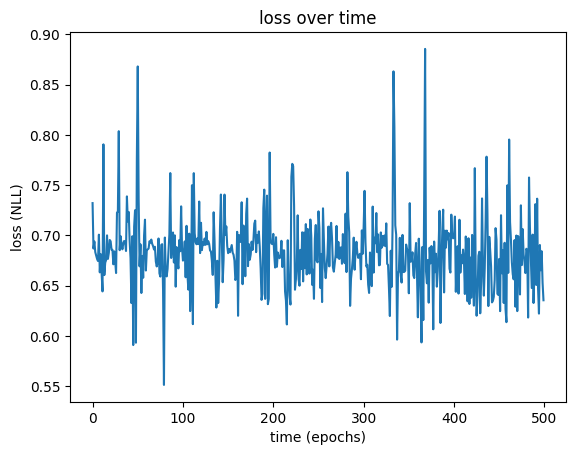

In [41]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 500
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG (not updated)

In [ ]:
#@title get batch gradient (not updated)
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

In [ ]:
#@title run batch_DLG on one batch (not updated)
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Effectiveness on Different Number of Inputs

In [59]:
# compute list with valid (inp_cnt_num, inp_cnt_cat) pairs for random selection among numerical and categorical (+ multiple rounds)
tups = [[] for i in range(9+16+1)]
for i in range(9):
    for j in range(16):
        tups[i+j+2].append((i+1, j+1))

# for nvars in np.arange(2, 25+1):
#     i, j = tups[nvars][random.randint(0, len(tups[nvars]) - 1)]
#     print(nvars, ': ', i, j)

In [60]:
# results of training a model + dlg
net.apply(weights_init)
Nvars = []
errors = []
epochs = 5
batch_size = 1
dlg_rate = 1
verbose = True
for nvars in np.arange(2, 25+1):
    i, j = tups[nvars][random.randint(0, len(tups[nvars]) - 1)]

    net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = i, inp_cnt_cat = j)
    losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
        = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=1000, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = True)
    
    Nvars.append(nvars)
    errors.append(torch.flatten(torch.tensor(AA_REs)).numpy())
    print(f'using {nvars} variables: ', AA_REs)
#test_net(net, test_data, test_target)

numerical variables: ['Familyincome']
[[3]
 [1]
 [2]
 ...
 [2]
 [1]
 [1]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['Peripheralarterydisease']
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 1.12721738  0.50891024 -0.50891024  0.        ]
 [-0.98856278  0.50891024 -0.50891024  0.        ]
 [ 0.0693273   0.50891024 -0.50891024  0.        ]
 ...
 [ 0.0693273   0.50891024 -0.50891024  0.        ]
 [-0.98856278  0.50891024 -0.50891024  0.        ]
 [-0.98856278  0.50891024 -0.50891024  0.        ]]
dimensions:  4 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4., 1., 0., 0.], dtype=torch.float64) tensor([ 4.0000e+00,  1.0000e+00, -4.3729e-05, -8.7673e-05]) RE (AE / TN):  2.3809637234473693e-05
closest match: assignment and relative error (%):
tensor([ 4.0000e+00,  1.0000e+00, -4.3729e-05, -8.7673e-05],
       dtype=torch.float64) tensor([4., 1., 0., 0.], dtype=torch.float64) 0.002380807914468856


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1., 0., 1., 0.], dtype=torch.float64) tensor([9.9989e-01, 8.9706e-05, 1.0002e+00, 6.7095e-04]) RE (AE / TN):  0.0005007463270628564
closest match: assignment and relative error (%):
tensor([9.9989e-01, 8.9706e-05, 1.0002e+00, 6.7095e-04], dtype=torch.float64) tensor([1., 0., 1., 0.], dtype=torch.float64) 0.050073923859420486


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3., 1., 0., 0.], dtype=torch.float64) tensor([ 3.0000e+00,  1.0000e+00, -4.2549e-05, -8.7835e-05]) RE (AE / TN):  3.1093862085638094e-05
closest match: assignment and relative error (%):
tensor([ 3.0000e+00,  1.0000e+00, -4.2549e-05, -8.7835e-05],
       dtype=torch.float64) tensor([3., 1., 0., 0.], dtype=torch.float64) 0.0031091667554046178


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4., 1., 0., 0.], dtype=torch.float64) tensor([ 4.0000e+00,  1.0000e+00, -3.1321e-05, -6.2964e-05]) RE (AE / TN):  1.708788529841943e-05
closest match: assignment and relative error (%):
tensor([ 4.0000e+00,  1.0000e+00, -3.1321e-05, -6.2964e-05],
       dtype=torch.float64) tensor([4., 1., 0., 0.], dtype=torch.float64) 0.0017084635743293357


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2., 1., 0., 0.], dtype=torch.float64) tensor([ 2.0051,  0.9987,  0.0096, -0.0134]) RE (AE / TN):  0.007735746690704337
closest match: assignment and relative error (%):
tensor([ 2.0051,  0.9987,  0.0096, -0.0134], dtype=torch.float64) tensor([2., 1., 0., 0.], dtype=torch.float64) 0.7735740948800077
using 2 variables:  [[2.3809637234473693e-05], [0.0005007463270628564], [3.1093862085638094e-05], [1.708788529841943e-05], [0.007735746690704337]]
numerical variables: ['timeofpredialysiscare' 'Centerexperiencepatientyear']
[[36.       30.763889]
 [26.       30.763889]
 [72.       30.763889]
 ...
 [10.       16.416667]
 [11.       16.416667]
 [ 0.       16.416667]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['HBC']
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[ 0.63675017 -0.43880709  0.02961225 -0.02961225  0.        ]
 [

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 14.9306,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-2.3525e-02,  1.4871e+01,  9.9988e-01, -5.6600e-05, -8.0132e-03]) RE (AE / TN):  0.004323496043903978
closest match: assignment and relative error (%):
tensor([-2.3525e-02,  1.4871e+01,  9.9988e-01, -5.6600e-05, -8.0132e-03],
       dtype=torch.float64) tensor([ 0.0000, 14.9306,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.4323495794850707


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 51.9444,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 8.4954e-05,  5.1943e+01,  1.0000e+00, -4.7591e-07,  2.2523e-04]) RE (AE / TN):  2.1026356761226794e-05
closest match: assignment and relative error (%):
tensor([ 8.4954e-05,  5.1943e+01,  1.0000e+00, -4.7591e-07,  2.2523e-04],
       dtype=torch.float64) tensor([ 0.0000, 51.9444,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.0021025918858035477


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 11.7333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-1.4399e-04,  1.1732e+01,  1.0000e+00, -5.9985e-07,  2.0808e-04]) RE (AE / TN):  0.00011002252997384905
closest match: assignment and relative error (%):
tensor([-1.4399e-04,  1.1732e+01,  1.0000e+00, -5.9985e-07,  2.0808e-04],
       dtype=torch.float64) tensor([ 0.0000, 11.7333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.011005247608596308


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000, 32.4667,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-4.8046e-02,  3.2331e+01,  9.9972e-01, -1.1921e-04, -1.8138e-02]) RE (AE / TN):  0.004477309417632138
closest match: assignment and relative error (%):
tensor([-4.8046e-02,  3.2331e+01,  9.9972e-01, -1.1921e-04, -1.8138e-02],
       dtype=torch.float64) tensor([ 0.0000, 32.4667,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.44772877411561085


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([12.0000, 13.8333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 1.1993e+01,  1.3825e+01,  9.9998e-01, -4.1602e-06, -1.9757e-03]) RE (AE / TN):  0.0006122069675063308
closest match: assignment and relative error (%):
tensor([ 1.1993e+01,  1.3825e+01,  9.9998e-01, -4.1602e-06, -1.9757e-03],
       dtype=torch.float64) tensor([12.0000, 13.8333,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 0.06121979254975858
using 3 variables:  [[0.004323496043903978], [2.1026356761226794e-05], [0.00011002252997384905], [0.004477309417632138], [0.0006122069675063308]]
numerical variables: ['Primaryrenaldisease' 'Centerexperiencepatientyear' 'BMI']
[[81.       30.763889 20.7     ]
 [ 0.       30.763889 28.3     ]
 [81.       30.763889 31.5     ]
 ...
 [50.       16.416667 23.5     ]
 [50.       16.416667 35.      ]
 [81.       16.416667 20.6     ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['HIV']
[[1 0 0]
 [1 0 0]
 [1

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.0000e+02, 5.9042e+01, 2.5200e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) tensor([1.0000e+02, 5.9042e+01, 2.5200e+01, 1.0000e+00, 1.2330e-06, 2.7690e-05]) RE (AE / TN):  4.212199333270705e-06
closest match: assignment and relative error (%):
tensor([1.0000e+02, 5.9042e+01, 2.5200e+01, 1.0000e+00, 1.2330e-06, 2.7690e-05],
       dtype=torch.float64) tensor([1.0000e+02, 5.9042e+01, 2.5200e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) 0.00042194233967929415


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([0.0000e+00, 6.5958e+01, 1.9900e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.1110e-02,  6.5635e+01,  1.9900e+01,  1.0004e+00, -5.1746e-04,
        -1.4730e-03]) RE (AE / TN):  0.0047324196695172184
closest match: assignment and relative error (%):
tensor([ 4.1110e-02,  6.5635e+01,  1.9900e+01,  1.0004e+00, -5.1746e-04,
        -1.4730e-03], dtype=torch.float64) tensor([0.0000e+00, 6.5958e+01, 1.9900e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) 0.47323765151923347


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.0000e+01, 8.1972e+01, 2.6000e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) tensor([ 1.0009e+01,  8.1954e+01,  2.6000e+01,  9.9997e-01, -6.2609e-05,
         4.9576e-04]) RE (AE / TN):  0.0002366950115323856
closest match: assignment and relative error (%):
tensor([ 1.0009e+01,  8.1954e+01,  2.6000e+01,  9.9997e-01, -6.2609e-05,
         4.9576e-04], dtype=torch.float64) tensor([1.0000e+01, 8.1972e+01, 2.6000e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) 0.023673315495621336


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([0.0000e+00, 6.5958e+01, 2.6900e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) tensor([ 7.4518, 21.0692, 24.2091,  0.9519, -0.0614, -2.5600]) RE (AE / TN):  0.6408613273370716
closest match: assignment and relative error (%):
tensor([ 7.4518, 21.0692, 24.2091,  0.9519, -0.0614, -2.5600],
       dtype=torch.float64) tensor([0.0000e+00, 6.5958e+01, 2.6900e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) 64.08613366235828


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.0000e+01, 5.4069e+01, 2.9500e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) tensor([ 2.9265e+01,  5.3883e+01,  2.9284e+01,  9.9785e-01, -1.3857e-02,
        -1.2218e-01]) RE (AE / TN):  0.01165211235242721
closest match: assignment and relative error (%):
tensor([ 2.9265e+01,  5.3883e+01,  2.9284e+01,  9.9785e-01, -1.3857e-02,
        -1.2218e-01], dtype=torch.float64) tensor([3.0000e+01, 5.4069e+01, 2.9500e+01, 1.0000e+00, 8.6736e-19, 0.0000e+00],
       dtype=torch.float64) 1.1652105091504545
using 4 variables:  [[4.212199333270705e-06], [0.0047324196695172184], [0.0002366950115323856], [0.6408613273370716], [0.01165211235242721]]
numerical variables: ['Age' 'DaviesScore' 'Familyincome' 'BMI']
[[71.2  0.   3.  20.7]
 [23.3  0.   1.  28.3]
 [49.2  1.   2.  31.5]
 ...
 [84.   0.   2.  23.5]
 [54.2  0.   1.  35. ]
 [77.8  0.   1.  20.6]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['Previoust

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.8500e+01, -1.1102e-16,  3.0000e+00,  2.3200e+01,  1.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.8495e+01, -2.6669e-04,  2.9999e+00,  2.3200e+01,  1.0000e+00,
         1.1090e-05,  2.1389e-04]) RE (AE / TN):  0.00010282695296570435
closest match: assignment and relative error (%):
tensor([ 3.8495e+01, -2.6669e-04,  2.9999e+00,  2.3200e+01,  1.0000e+00,
         1.1090e-05,  2.1389e-04], dtype=torch.float64) tensor([ 3.8500e+01, -1.1102e-16,  3.0000e+00,  2.3200e+01,  1.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) 0.010284339586800665


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([57.4000,  1.0000,  2.0000, 24.0000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) tensor([5.7397e+01, 9.9982e-01, 1.9999e+00, 2.4000e+01, 1.0000e+00, 7.2969e-06,
        1.4460e-04]) RE (AE / TN):  4.9271784301549903e-05
closest match: assignment and relative error (%):
tensor([5.7397e+01, 9.9982e-01, 1.9999e+00, 2.4000e+01, 1.0000e+00, 7.2969e-06,
        1.4460e-04], dtype=torch.float64) tensor([57.4000,  1.0000,  2.0000, 24.0000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) 0.004925229412144117


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([69.1000,  1.0000,  2.0000, 28.0000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) tensor([6.9100e+01, 9.9997e-01, 2.0000e+00, 2.8000e+01, 1.0000e+00, 9.3936e-07,
        2.0215e-05]) RE (AE / TN):  5.358756758760807e-06
closest match: assignment and relative error (%):
tensor([6.9100e+01, 9.9997e-01, 2.0000e+00, 2.8000e+01, 1.0000e+00, 9.3936e-07,
        2.0215e-05], dtype=torch.float64) tensor([69.1000,  1.0000,  2.0000, 28.0000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) 0.0005346285272733541


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([76.0000,  3.0000,  3.0000, 23.5000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) tensor([7.5998e+01, 2.9999e+00, 3.0000e+00, 2.3500e+01, 1.0000e+00, 3.7355e-06,
        1.0179e-04]) RE (AE / TN):  2.7199771307002115e-05
closest match: assignment and relative error (%):
tensor([7.5998e+01, 2.9999e+00, 3.0000e+00, 2.3500e+01, 1.0000e+00, 3.7355e-06,
        1.0179e-04], dtype=torch.float64) tensor([76.0000,  3.0000,  3.0000, 23.5000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) 0.0027236161847154815


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([50.0000,  1.0000,  3.0000, 23.3000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) tensor([ 5.0001e+01,  1.0000e+00,  3.0000e+00,  2.3300e+01,  1.0000e+00,
         1.2623e-06, -1.4858e-05]) RE (AE / TN):  9.817501259969092e-06
closest match: assignment and relative error (%):
tensor([ 5.0001e+01,  1.0000e+00,  3.0000e+00,  2.3300e+01,  1.0000e+00,
         1.2623e-06, -1.4858e-05], dtype=torch.float64) tensor([50.0000,  1.0000,  3.0000, 23.3000,  1.0000,  0.0000,  0.0000],
       dtype=torch.float64) 0.0009826126622844663
using 5 variables:  [[0.00010282695296570435], [4.9271784301549903e-05], [5.358756758760807e-06], [2.7199771307002115e-05], [9.817501259969092e-06]]
numerical variables: ['CenterSizenpatients' 'Familyincome']
[[128   3]
 [128   1]
 [128   2]
 ...
 [ 66   2]
 [ 66   1]
 [ 66   1]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['PrevalentinPDNet' 'Previoustx' 'Race' 'predialysiscare']
[[1 0 1

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([161.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.], dtype=torch.float64) tensor([ 1.6102e+02,  1.9998e+00,  1.0001e+00, -1.9125e-05,  1.0000e+00,
         1.0310e-05, -1.4275e-04,  1.0001e+00, -1.5287e-05, -1.0093e-04,
        -3.1938e-04,  8.0130e-06, -1.6772e-04,  1.0002e+00,  1.7856e-04,
         1.6868e-04]) RE (AE / TN):  0.0001314788158776319
closest match: assignment and relative error (%):
tensor([ 1.6102e+02,  1.9998e+00,  1.0001e+00, -1.9125e-05,  1.0000e+00,
         1.0310e-05, -1.4275e-04,  1.0001e+00, -1.5287e-05, -1.0093e-04,
        -3.1938e-04,  8.0130e-06, -1.6772e-04,  1.0002e+00,  1.7856e-04,
         1.6868e-04], dtype=torch.float64) tensor([161.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.], dtype=torch.float64) 0.013152343819256456


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([358.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.], dtype=torch.float64) tensor([ 3.6144e+02,  1.9759e+00,  1.0237e+00,  1.7381e-02,  9.8684e-01,
         3.1811e-03,  3.4694e-03,  1.0030e+00,  7.1781e-04,  2.1965e-03,
        -3.1353e-02,  3.4050e-05,  1.6001e-02,  1.0093e+00, -2.0516e-04,
        -3.7545e-02]) RE (AE / TN):  0.009599603121910933
closest match: assignment and relative error (%):
tensor([ 3.6144e+02,  1.9759e+00,  1.0237e+00,  1.7381e-02,  9.8684e-01,
         3.1811e-03,  3.4694e-03,  1.0030e+00,  7.1781e-04,  2.1965e-03,
        -3.1353e-02,  3.4050e-05,  1.6001e-02,  1.0093e+00, -2.0516e-04,
        -3.7545e-02], dtype=torch.float64) tensor([358.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.], dtype=torch.float64) 0.9599591301184112


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([398.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.], dtype=torch.float64) tensor([ 3.9800e+02,  2.0000e+00,  1.0000e+00,  2.2713e-05,  9.9999e-01,
        -3.6244e-06,  7.5194e-05,  8.9652e-07,  5.4961e-06,  1.0000e+00,
         4.2497e-05, -3.0211e-06,  2.4736e-05, -3.9591e-05,  9.9992e-01,
        -6.8717e-05]) RE (AE / TN):  8.672522852774234e-06
closest match: assignment and relative error (%):
tensor([ 3.9800e+02,  2.0000e+00,  1.0000e+00,  2.2713e-05,  9.9999e-01,
        -3.6244e-06,  7.5194e-05,  8.9652e-07,  5.4961e-06,  1.0000e+00,
         4.2497e-05, -3.0211e-06,  2.4736e-05, -3.9591e-05,  9.9992e-01,
        -6.8717e-05], dtype=torch.float64) tensor([398.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.], dtype=torch.float64) 0.0008645067692965026


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([39.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.], dtype=torch.float64) tensor([ 3.9001e+01,  2.0000e+00,  1.0000e+00,  8.9522e-07,  9.9999e-01,
        -1.8661e-06,  3.7041e-05,  9.9999e-01,  4.5318e-06,  2.9572e-06,
         2.8228e-05, -1.6842e-06,  1.8818e-05,  9.9998e-01, -4.4178e-05,
        -3.9946e-05]) RE (AE / TN):  1.7108565566591887e-05
closest match: assignment and relative error (%):
tensor([ 3.9001e+01,  2.0000e+00,  1.0000e+00,  8.9522e-07,  9.9999e-01,
        -1.8661e-06,  3.7041e-05,  9.9999e-01,  4.5318e-06,  2.9572e-06,
         2.8228e-05, -1.6842e-06,  1.8818e-05,  9.9998e-01, -4.4178e-05,
        -3.9946e-05], dtype=torch.float64) tensor([39.,  2.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.], dtype=torch.float64) 0.0017066886219583271


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([146.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.], dtype=torch.float64) tensor([ 1.4600e+02,  2.0000e+00,  1.0000e+00,  6.7339e-06,  9.9998e-01,
        -3.9921e-06,  6.6096e-05,  9.9999e-01,  6.8514e-06,  3.6393e-06,
         4.8951e-05, -3.2002e-06,  1.9041e-05, -4.4538e-05,  9.9992e-01,
        -7.0962e-05]) RE (AE / TN):  1.3518354646842626e-05
closest match: assignment and relative error (%):
tensor([ 1.4600e+02,  2.0000e+00,  1.0000e+00,  6.7339e-06,  9.9998e-01,
        -3.9921e-06,  6.6096e-05,  9.9999e-01,  6.8514e-06,  3.6393e-06,
         4.8951e-05, -3.2002e-06,  1.9041e-05, -4.4538e-05,  9.9992e-01,
        -7.0962e-05], dtype=torch.float64) tensor([146.,   2.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.], dtype=torch.float64) 0.0013515053085941327
using 6 variables:  [[0.0001314788158776319], [0.009599603121910933], [

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.3100e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.3096e+01,  1.0001e+00,  1.0000e+00,  3.7441e-05,  3.7843e-06,
         1.0000e+00,  1.5300e-05,  1.3678e-04, -9.9821e-05,  9.9997e-01,
        -3.4364e-04,  1.0000e+00, -8.2561e-05, -5.0444e-05,  8.3571e-05,
         9.9985e-01, -1.5795e-06,  5.5560e-06, -7.7491e-05, -2.0840e-04]) RE (AE / TN):  7.767625090415301e-05
closest match: assignment and relative error (%):
tensor([ 5.3096e+01,  1.0001e+00,  1.0000e+00,  3.7441e-05,  3.7843e-06,
         1.0000e+00,  1.5300e-05,  1.3678e-04, -9.9821e-05,  9.9997e-01,
        -3.4364e-04,  1.0000e+00, -8.2561e-05, -5.0444e-05,  8.3571e-05,
         9.9985e-01, -1.5795e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([35.2000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 3.5195e+01,  1.0001e+00,  1.0000e+00,  2.3274e-05,  8.9101e-05,
         1.0000e+00,  1.8532e-05,  1.1422e-04, -7.2964e-05,  9.9998e-01,
        -2.9876e-04,  1.5719e-05,  9.9994e-01, -1.0230e-04,  1.0000e+00,
        -9.6218e-05, -3.8395e-06,  7.5930e-07, -6.0713e-05, -1.6085e-04]) RE (AE / TN):  0.00013069732893874973
closest match: assignment and relative error (%):
tensor([ 3.5195e+01,  1.0001e+00,  1.0000e+00,  2.3274e-05,  8.9101e-05,
         1.0000e+00,  1.8532e-05,  1.1422e-04, -7.2964e-05,  9.9998e-01,
        -2.9876e-04,  1.5719e-05,  9.9994e-01, -1.0230e-04,  1.0000e+00,
        -9.6218e-05, -3.8395e-06,  7.5930e-07, -6.0713e-05, -1.6085e-04],
       dtype=torch.float64) tensor([35.2000,  1.0000

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4100e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 6.4102e+01,  9.9994e-01,  9.9998e-01, -1.8142e-05,  1.8825e-05,
         9.9999e-01, -3.0511e-06, -4.2415e-05,  5.5369e-05,  1.0000e+00,
         1.3736e-04,  1.0001e+00,  4.8325e-05, -3.2731e-05, -4.9623e-05,
         1.0001e+00, -2.8172e-06, -1.2126e-05,  3.2414e-05,  1.6450e-04]) RE (AE / TN):  3.165039106110177e-05
closest match: assignment and relative error (%):
tensor([ 6.4102e+01,  9.9994e-01,  9.9998e-01, -1.8142e-05,  1.8825e-05,
         9.9999e-01, -3.0511e-06, -4.2415e-05,  5.5369e-05,  1.0000e+00,
         1.3736e-04,  1.0001e+00,  4.8325e-05, -3.2731e-05, -4.9623e-05,
         1.0001e+00, -2.8172e-06

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.4300e+01,  2.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 7.4294e+01,  2.0001e+00,  1.0000e+00,  4.2549e-05,  6.1234e-05,
         1.0001e+00,  7.5103e-06,  1.6288e-04, -1.3491e-04,  9.9997e-01,
        -4.4916e-04,  2.0219e-05,  9.9989e-01, -9.5597e-05,  8.9094e-05,
         9.9982e-01,  1.3110e-05, -4.4452e-06, -1.0635e-04, -2.7424e-04]) RE (AE / TN):  8.086669052215e-05
closest match: assignment and relative error (%):
tensor([ 7.4294e+01,  2.0001e+00,  1.0000e+00,  4.2549e-05,  6.1234e-05,
         1.0001e+00,  7.5103e-06,  1.6288e-04, -1.3491e-04,  9.9997e-01,
        -4.4916e-04,  2.0219e-05,  9.9989e-01, -9.5597e-05,  8.9094e-05,
         9.9982e-01,  1.3110e-05, -

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.1300e+01,  3.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 4.1302e+01,  2.9999e+00,  9.9998e-01, -1.1854e-05,  2.4302e-05,
         9.9999e-01, -7.2746e-06, -6.3943e-05,  6.7695e-05,  1.0000e+00,
         1.5915e-04,  1.0001e+00,  5.1126e-05,  2.7555e-06, -6.2187e-05,
         6.9946e-05, -1.0466e-05,  1.0000e+00,  3.2966e-05,  2.3325e-04]) RE (AE / TN):  4.5694809627584085e-05
closest match: assignment and relative error (%):
tensor([ 4.1302e+01,  2.9999e+00,  9.9998e-01, -1.1854e-05,  2.4302e-05,
         9.9999e-01, -7.2746e-06, -6.3943e-05,  6.7695e-05,  1.0000e+00,
         1.5915e-04,  1.0001e+00,  5.1126e-05,  2.7555e-06, -6.2187e-05,
         6.9946e-05, -1.0466e-0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([66.0000, 33.5000, 11.0000, 16.4167, 20.4000,  1.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([-0.2671, 17.6489, 11.8334,  8.7571, 17.6904,  0.3166, -0.6500,  1.0465,
        -0.1690, -0.2445,  1.0560,  0.0770, -0.5726]) RE (AE / TN):  0.8655360330906491
closest match: assignment and relative error (%):
tensor([-0.2671, 17.6489, 11.8334,  8.7571, 17.6904,  0.3166, -0.6500,  1.0465,
        -0.1690, -0.2445,  1.0560,  0.0770, -0.5726], dtype=torch.float64) tensor([66.0000, 33.5000, 11.0000, 16.4167, 20.4000,  1.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000], dtype=torch.float64) 86.55360316085051


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  59.5000,  27.0000,  81.9722,  27.3000,   1.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([ 3.2000e+02,  5.9501e+01,  2.7001e+01,  8.1973e+01,  2.7300e+01,
         1.0000e+00,  2.8488e-05,  1.0000e+00,  1.6151e-05, -1.5296e-05,
         1.0000e+00,  4.3852e-06,  1.9827e-05]) RE (AE / TN):  4.378769332489011e-06
closest match: assignment and relative error (%):
tensor([ 3.2000e+02,  5.9501e+01,  2.7001e+01,  8.1973e+01,  2.7300e+01,
         1.0000e+00,  2.8488e-05,  1.0000e+00,  1.6151e-05, -1.5296e-05,
         1.0000e+00,  4.3852e-06,  1.9827e-05], dtype=torch.float64) tensor([320.0000,  59.5000,  27.0000,  81.9722,  27.3000,   1.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) 0.0004360315531249897


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([143.0000,  70.7000,   0.0000,  29.0000,  23.9000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([43.5143, 27.5743, -7.1233, 24.7293, 13.4261, -3.3058, -5.5618,  1.6728,
        -0.4666,  4.1426,  1.3927,  0.0488, -4.5240]) RE (AE / TN):  0.6691507723242703
closest match: assignment and relative error (%):
tensor([43.5143, 27.5743, -7.1233, 24.7293, 13.4261, -3.3058, -5.5618,  1.6728,
        -0.4666,  4.1426,  1.3927,  0.0488, -4.5240], dtype=torch.float64) tensor([143.0000,  70.7000,   0.0000,  29.0000,  23.9000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) 66.91507758081207


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  24.0000,  12.0000,  81.9722,  27.3000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([215.3293, -50.4110, -42.3791, 103.6187,  15.6454,  -3.2591,  -4.5426,
          1.4887,  -0.6262,   2.4885,   0.7350,  -0.4381,  -5.1267]) RE (AE / TN):  0.4266553923992313
closest match: assignment and relative error (%):
tensor([215.3293, -50.4110, -42.3791, 103.6187,  15.6454,  -3.2591,  -4.5426,
          1.4887,  -0.6262,   2.4885,   0.7350,  -0.4381,  -5.1267],
       dtype=torch.float64) tensor([320.0000,  24.0000,  12.0000,  81.9722,  27.3000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) 42.66553843878153


  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([172.0000,  63.3000,  24.0000,  32.4667,  31.5000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([ 1.7200e+02,  6.3300e+01,  2.4000e+01,  3.2467e+01,  3.1500e+01,
         1.0000e+00,  1.1738e-06, -9.6041e-08,  1.0000e+00, -4.4323e-07,
         1.0000e+00,  6.2663e-07,  1.4284e-06]) RE (AE / TN):  3.379040097759042e-07
closest match: assignment and relative error (%):
tensor([ 1.7200e+02,  6.3300e+01,  2.4000e+01,  3.2467e+01,  3.1500e+01,
         1.0000e+00,  1.1738e-06, -9.6041e-08,  1.0000e+00, -4.4323e-07,
         1.0000e+00,  6.2663e-07,  1.4284e-06], dtype=torch.float64) tensor([172.0000,  63.3000,  24.0000,  32.4667,  31.5000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) 3.319321396697898e-05
using 8 variables:  [[0.8655360330906491], [4.378769332489011e-06], [0.6691507723242

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.3100e+01, -1.1102e-16,  2.0000e+00,  0.0000e+00,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.3096e+01,  7.4175e-05,  2.0001e+00,  3.3328e-03,  1.0000e+00,
         1.0000e+00,  1.1649e-05,  1.3970e-04,  9.9998e-01, -5.0707e-06,
        -3.9866e-04,  1.0000e+00, -8.1747e-06, -1.0291e-04,  1.1611e-04,
        -4.5201e-05, -1.0954e-05,  9.9998e-01, -1.2480e-05, -2.0362e-04]) RE (AE / TN):  0.0001051953986346101
closest match: assignment and relative error (%):
tensor([ 5.3096e+01,  7.4175e-05,  2.0001e+00,  3.3328e-03,  1.0000e+00,
         1.0000e+00,  1.1649e-05,  1.3970e-04,  9.9998e-01, -5.0707e-06,
        -3.9866e-04,  1.0000e+00, -8.1747e-06, -1.0291e-04,  1.1611e-04,
        -4.5201e-05, -1.0954e-05

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5200e+01, -1.1102e-16,  2.0000e+00,  1.2000e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.5196e+01,  6.1765e-05,  2.0001e+00,  1.2002e+01,  1.0000e+00,
         1.0000e+00,  1.6840e-05,  1.0130e-04,  9.9999e-01, -3.8451e-06,
        -3.1812e-04,  1.0000e+00, -7.4121e-06, -8.5181e-05,  1.0001e+00,
        -4.1700e-05, -8.3715e-06,  3.5145e-06, -9.8322e-06, -1.8111e-04]) RE (AE / TN):  0.00012460024774941177
closest match: assignment and relative error (%):
tensor([ 3.5196e+01,  6.1765e-05,  2.0001e+00,  1.2002e+01,  1.0000e+00,
         1.0000e+00,  1.6840e-05,  1.0130e-04,  9.9999e-01, -3.8451e-06,
        -3.1812e-04,  1.0000e+00, -7.4121e-06, -8.5181e-05,  1.0001e+00,
        -4.1700e-05, -8.3715e-0

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4100e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 6.4102e+01,  9.9995e-01,  2.0000e+00, -1.2390e-03,  1.0000e+00,
         9.9998e-01, -2.3729e-06, -2.6358e-05,  1.0000e+00,  2.1087e-06,
         1.4442e-04,  1.0000e+00,  6.6644e-06, -1.5491e-05,  9.9995e-01,
         2.1081e-05, -3.9375e-06, -1.2639e-05,  4.8891e-06,  1.8306e-04]) RE (AE / TN):  4.082456515511334e-05
closest match: assignment and relative error (%):
tensor([ 6.4102e+01,  9.9995e-01,  2.0000e+00, -1.2390e-03,  1.0000e+00,
         9.9998e-01, -2.3729e-06, -2.6358e-05,  1.0000e+00,  2.1087e-06,
         1.4442e-04,  1.0000e+00,  6.6644e-06, -1.5491e-05,  9.9995e-01,
         2.1081e-05, -3.9375e-06, -1.2639e-05,  4.8891e-06,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.4300e+01, 1.0000e+00, 4.0000e+00, 2.4000e+01, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 7.4293e+01,  1.0001e+00,  4.0001e+00,  2.4003e+01,  2.0000e+00,
         1.0001e+00,  1.5734e-05,  1.2138e-04,  9.9998e-01, -3.9672e-06,
        -4.5248e-04,  1.0000e+00, -1.3216e-05, -4.5482e-05,  1.0001e+00,
        -6.0638e-05,  1.4213e-05,  8.7894e-06, -1.6842e-05, -2.8647e-04]) RE (AE / TN):  9.358304342453044e-05
closest match: assignment and relative error (%):
tensor([ 7.4293e+01,  1.0001e+00,  4.0001e+00,  2.4003e+01,  2.0000e+00,
         1.0001e+00,  1.5734e-05,  1.2138e-04,  9.9998e-01, -3.9672e-06,
        -4.5248e-04,  1.0000e+00, -1.3216e-05, -4.5482e-05,  1.0001e+00,
        -6.0638e-05,  1.4213e-05,  8.7894e-06, -1.6842e-05,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.1300e+01, -1.1102e-16,  1.0000e+00,  0.0000e+00,  3.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 4.1302e+01, -4.8560e-05,  9.9996e-01, -1.5886e-03,  3.0000e+00,
         9.9998e-01, -4.8064e-06, -7.7769e-05,  1.0000e+00,  3.7910e-06,
         1.6542e-04,  1.0000e+00,  4.3291e-06,  6.4241e-07, -7.3052e-05,
         2.4791e-05, -9.0537e-06,  1.0000e+00,  5.1329e-06,  1.8194e-04]) RE (AE / TN):  5.959168533351555e-05
closest match: assignment and relative error (%):
tensor([ 4.1302e+01, -4.8560e-05,  9.9996e-01, -1.5886e-03,  3.0000e+00,
         9.9999e-01, -4.8064e-06, -7.7769e-05,  1.0000e+00,  3.7910e-06,
         1.6542e-04,  1.0000e+00,  4.3291e-06,  6.4241e-07, -7.3052e-05,
         2.4791e-05, -9.0537e-06

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([30.0000, 60.4000,  0.0000, 23.7000,  1.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000], dtype=torch.float64) tensor([ 3.0001e+01,  6.0401e+01,  7.7711e-04,  2.3700e+01,  1.0000e+00,
         4.8142e-05,  9.9998e-01, -1.2913e-05, -9.9175e-05,  9.9999e-01,
         2.5670e-06,  1.0202e-04,  1.0000e+00, -1.1733e-05,  4.2391e-05,
         1.0000e+00,  3.4038e-06, -2.2189e-05,  1.0000e+00, -4.5251e-05,
         7.4027e-05]) RE (AE / TN):  2.328729246164744e-05
closest match: assignment and relative error (%):
tensor([ 3.0001e+01,  6.0401e+01,  7.7711e-04,  2.3700e+01,  1.0000e+00,
         4.8142e-05,  9.9998e-01, -1.2913e-05, -9.9175e-05,  9.9999e-01,
         2.5670e-06,  1.0202e-04,  1.0000e+00, -1.1733e-05,  4.2391e-05,
         1.0000e+00,  3.4038e-06, -2.2189e-05,  1.0000e+00, -4.5251e-05,
         7.4027e-05], dt

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([398.0000,  62.5000,   6.0000,  24.4000,   1.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) tensor([ 3.9801e+02,  6.2497e+01,  5.9948e+00,  2.4399e+01,  9.9988e-01,
        -3.0397e-04,  1.0001e+00,  3.6783e-06,  4.0245e-04,  1.0001e+00,
         1.2536e-05, -1.4818e-04,  9.9996e-01,  5.0813e-05,  9.0696e-06,
         9.9997e-01,  3.8826e-06,  1.1321e-04, -5.1482e-05,  1.0001e+00,
        -2.4116e-04]) RE (AE / TN):  2.1663085312529748e-05
closest match: assignment and relative error (%):
tensor([ 3.9801e+02,  6.2497e+01,  5.9948e+00,  2.4399e+01,  9.9988e-01,
        -3.0397e-04,  1.0001e+00,  3.6783e-06,  4.0245e-04,  1.0001e+00,
         1.2536e-05, -1.4818e-04,  9.9996e-01,  5.0813e-05,  9.0696e-06,
         9.9997e-01,  3.8826e-06,  1.1321e-04, -5.1482e-05,  1.0001e

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 33.0000,  46.0000, 120.0000,  22.7000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000],
       dtype=torch.float64) tensor([ 3.3006e+01,  4.5998e+01,  1.2000e+02,  2.2700e+01,  9.9997e-01,
        -1.2324e-04, -7.8032e-06,  1.0000e+00,  1.9722e-04,  1.0000e+00,
         3.2278e-06, -1.0901e-04, -1.0667e-05,  1.0000e+00, -1.3758e-05,
         9.9999e-01, -1.5963e-06,  4.3852e-05, -2.3380e-05,  1.0001e+00,
        -1.4977e-04]) RE (AE / TN):  5.228862279403417e-05
closest match: assignment and relative error (%):
tensor([ 3.3006e+01,  4.5998e+01,  1.2000e+02,  2.2700e+01,  9.9997e-01,
        -1.2324e-04, -7.8032e-06,  1.0000e+00,  1.9722e-04,  1.0000e+00,
         3.2278e-06, -1.0901e-04, -1.0667e-05,  1.0000e+00, -1.3758e-05,
         9.9999e-01, -1.5963e-06,  4.3852e-05, -2.3380e-05,  1.0001e+

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([140.0000,  73.2000,   0.0000,  19.5000,   1.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000],
       dtype=torch.float64) tensor([ 1.4000e+02,  7.3202e+01,  1.4675e-03,  1.9500e+01,  1.0001e+00,
         9.1039e-05,  9.9995e-01, -3.4269e-05, -1.8139e-04,  9.9998e-01,
         1.3780e-06,  1.7937e-04,  1.0000e+00, -2.4141e-05,  7.0512e-05,
         1.0000e+00,  5.6805e-06, -4.4273e-05,  1.0000e+00, -7.6542e-05,
         1.4678e-04]) RE (AE / TN):  2.6628953892034375e-05
closest match: assignment and relative error (%):
tensor([ 1.4000e+02,  7.3202e+01,  1.4675e-03,  1.9500e+01,  1.0001e+00,
         9.1039e-05,  9.9995e-01, -3.4269e-05, -1.8139e-04,  9.9998e-01,
         1.3780e-06,  1.7937e-04,  1.0000e+00, -2.4141e-05,  7.0512e-05,
         1.0000e+00,  5.6805e-06, -4.4273e-05,  1.0000e+00, -7.6542e

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.5800e+02,  7.0500e+01,  1.2000e+01,  2.2700e+01,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.1102e-16,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.5800e+02,  7.0501e+01,  1.2000e+01,  2.2700e+01,  9.9999e-01,
         1.5102e-05, -7.4502e-06,  9.9999e-01, -3.0462e-05,  1.0000e+00,
         2.2833e-06,  4.1498e-05,  1.0000e+00, -3.3729e-06,  2.4497e-05,
        -6.2955e-07,  1.0000e+00, -1.9033e-05,  6.1014e-07,  9.9998e-01,
         1.6799e-05]) RE (AE / TN):  5.347376743486664e-06
closest match: assignment and relative error (%):
tensor([ 1.5800e+02,  7.0501e+01,  1.2000e+01,  2.2700e+01,  9.9999e-01,
         1.5102e-05, -7.4502e-06,  9.9999e-01, -3.0462e-05,  1.0000e+00,
         2.2833e-06,  4.1498e-05,  1.0000e+00, -3.3729e-06,  2.4497e-0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([45.0000, 44.0000, 81.0000,  1.0000,  2.0000,  1.0000, 19.6000,  1.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000], dtype=torch.float64) tensor([-1.9900e+01,  3.5021e+01,  9.9004e+01,  2.0372e+00,  2.7545e+00,
        -7.5190e+00,  1.7703e+01,  9.7966e-01,  7.8413e-01, -1.4917e-01,
         3.7839e-01,  1.0182e+00, -1.3974e-01,  7.4542e-02,  9.1139e-01,
        -7.0579e-02,  3.7876e-01]) RE (AE / TN):  0.6558132637609242
closest match: assignment and relative error (%):
tensor([-1.9900e+01,  3.5021e+01,  9.9004e+01,  2.0372e+00,  2.7545e+00,
        -7.5190e+00,  1.7703e+01,  9.7966e-01,  7.8413e-01, -1.4917e-01,
         3.7839e-01,  1.0182e+00, -1.3974e-01,  7.4542e-02,  9.1139e-01,
        -7.0579e-02,  3.7876e-01], dtype=torch.float64) tensor([45.0000, 44.0000, 81.0000,  1.0000,  2.0000,  1.0000, 19.6000,  1.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([106.0000,  83.6000,  50.0000,   3.0000,   2.0000,   0.0000,  25.7000,
          1.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 1.0601e+02,  8.3596e+01,  5.0005e+01,  3.0001e+00,  2.0000e+00,
        -1.5141e-03,  2.5700e+01,  1.0000e+00,  9.9997e-01, -4.1228e-06,
         2.2217e-04,  1.0000e+00, -1.4580e-06, -2.2117e-04,  1.0000e+00,
         1.0273e-05, -3.0115e-04]) RE (AE / TN):  6.97787850554005e-05
closest match: assignment and relative error (%):
tensor([ 1.0601e+02,  8.3596e+01,  5.0005e+01,  3.0001e+00,  2.0000e+00,
        -1.5141e-03,  2.5700e+01,  1.0000e+00,  9.9997e-01, -4.1228e-06,
         2.2217e-04,  1.0000e+00, -1.4580e-06, -2.2117e-04,  1.0000e+00,
         1.0273e-05, -3.0115e-04], dtype=torch.float64) tensor([106.0000,  83.6000,  50.0000,   3.0000,   2.0000,   0.0000,  25.7000,
          1.0000,   1.0000,   0.0000,   0.0

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 33.0000,  48.1000, 100.0000,   1.0000,   1.0000,   0.0000,  24.4000,
          2.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([-2.2528e+00,  2.8503e+01,  7.8013e+01,  1.3843e+00,  1.1032e+00,
         5.4552e+00,  2.3974e+01,  1.7798e+00,  9.7649e-01, -4.6769e-02,
        -2.3296e-02,  9.5933e-01, -4.1366e-02,  2.7301e-01,  9.8200e-01,
        -1.8730e-02, -1.9171e-01]) RE (AE / TN):  0.39091535579263964
closest match: assignment and relative error (%):
tensor([-2.2528e+00,  2.8503e+01,  7.8013e+01,  1.3843e+00,  1.1032e+00,
         5.4552e+00,  2.3974e+01,  1.7798e+00,  9.7649e-01, -4.6769e-02,
        -2.3296e-02,  9.5933e-01, -4.1366e-02,  2.7301e-01,  9.8200e-01,
        -1.8730e-02, -1.9171e-01], dtype=torch.float64) tensor([ 33.0000,  48.1000, 100.0000,   1.0000,   1.0000,   0.0000,  24.4000,
          2.0000,   1.0000,   0.0000,   0.00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+02,  4.3300e+01,  1.0000e+02, -1.1102e-16,  3.0000e+00,
         1.5000e+01,  2.3700e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 2.0424e+02, -5.8952e+01,  2.2602e+02,  4.6006e+00,  1.0169e+01,
         1.0876e+02,  5.1201e+00,  8.3047e+00,  3.3934e-01, -1.0759e+00,
         2.8096e+00,  1.2514e+00, -7.0518e-01,  3.7792e+00,  6.2618e-01,
        -1.0764e-01, -1.2717e+00]) RE (AE / TN):  0.8225980131939071
closest match: assignment and relative error (%):
tensor([ 2.0424e+02, -5.8952e+01,  2.2602e+02,  4.6006e+00,  1.0169e+01,
         1.0876e+02,  5.1201e+00,  8.3047e+00,  3.3934e-01, -1.0759e+00,
         2.8096e+00,  1.2514e+00, -7.0519e-01,  3.7792e+00,  6.2618e-01,
        -1.0764e-01, -1.2717e+00], dtype=torch.float64) tensor([ 2.0000e+02,  4.3300e+01,  1.0000e+02, -1.1102e-16,  3.0

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([320.0000,  70.2000,  81.0000,   1.0000,   2.0000,   0.0000,  22.0000,
          2.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 3.2000e+02,  7.0201e+01,  8.0999e+01,  1.0000e+00,  2.0000e+00,
        -7.4386e-04,  2.2000e+01,  2.0000e+00,  1.0000e+00, -3.3925e-07,
        -2.2437e-05,  1.0000e+00, -4.4015e-07,  5.6484e-06,  1.0000e+00,
        -7.0939e-07,  4.9838e-07]) RE (AE / TN):  6.851139977865646e-06
closest match: assignment and relative error (%):
tensor([ 3.2000e+02,  7.0201e+01,  8.0999e+01,  1.0000e+00,  2.0000e+00,
        -7.4386e-04,  2.2000e+01,  2.0000e+00,  1.0000e+00, -3.3925e-07,
        -2.2437e-05,  1.0000e+00, -4.4015e-07,  5.6484e-06,  1.0000e+00,
        -7.0939e-07,  4.9838e-07], dtype=torch.float64) tensor([320.0000,  70.2000,  81.0000,   1.0000,   2.0000,   0.0000,  22.0000,
          2.0000,   1.0000,   0.0000,   0.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.7500e+01,  1.0000e+01, -1.1102e-16,  3.0000e+00,  3.2972e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 6.7503e+01,  1.0010e+01, -1.9959e-04,  3.0001e+00,  3.2974e+01,
         9.9981e-01,  9.9990e-01,  9.6606e-05, -3.3676e-05,  1.0001e+00,
         1.5985e-04,  1.2101e-04,  1.0000e+00, -5.5898e-06,  1.6293e-04,
         1.0000e+00,  3.5228e-05,  4.2650e-05, -7.7767e-05,  1.0001e+00,
         1.0570e-04,  1.0000e+00, -2.8438e-05,  2.0444e-05,  1.3342e-04,
         1.4221e-05, -1.0102e-04]) RE (AE / TN):  0.00013789315752315448
closest match: assignment and relative error (%):
tensor([ 6.7503e+01,  1.0010e+01, -1.9959e-

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.8000e+01,  0.0000e+00,  1.0000e+00,  1.0000e+00,  2.6300e+01,
         5.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 5.8116e+01,  6.9364e+01,  7.8443e-01,  2.9913e-01,  3.5277e+01,
         6.7646e+00,  9.6161e-01, -4.5244e-02,  5.1393e-01,  3.6817e-01,
         1.1820e+00, -9.1719e-01,  1.0203e+00, -7.1804e-02, -2.3638e-01,
         1.1034e+00, -7.8199e-01,  3.1462e-01,  8.9464e-01, -6.0363e-01,
         1.2389e+00,  2.0056e-01, -3.9403e-01, -2.5388e-01,  1.5611e+00,
         3.6744e-01,  6.9006e-01]) RE (AE / TN):  1.285263863480214
closest match: assignment and relative error (%):
tensor([ 5.8116e+01,  6.9364e+01,  7.8443e-01,  

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.8000e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,  1.2062e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 4.8002e+01,  5.0007e+01, -1.1724e-04,  2.0001e+00,  1.2064e+01,
         9.9982e-01,  9.9994e-01,  7.1984e-05, -4.3913e-05,  1.0001e+00,
         9.8330e-05,  6.7229e-05,  1.0000e+00, -5.2700e-06,  1.0794e-04,
         1.0000e+00,  2.3976e-05,  2.4533e-05, -5.4343e-05,  1.0001e+00,
         8.3720e-05,  2.2678e-05,  9.9999e-01,  8.5059e-06,  9.4121e-05,
         1.0926e-05, -9.0415e-05]) RE (AE / TN):  9.853666910523084e-05
closest match: assignment and relative error (%):
tensor([ 4.8002e+01,  5.0007e+01, -1.1724e-0

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.9000e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,  3.8050e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 5.9003e+01,  8.1009e+01,  9.9979e-01,  1.0001e+00,  3.8051e+01,
         9.9978e-01,  9.9988e-01,  1.0796e-04, -1.3272e-04,  9.2400e-05,
         1.0001e+00,  7.1816e-05,  1.0000e+00, -1.4142e-05,  1.7851e-04,
         5.5685e-05,  1.0001e+00,  4.4774e-05,  9.9990e-01,  1.4667e-04,
         1.2636e-04,  5.4801e-05,  9.9999e-01,  2.5087e-05,  1.2397e-04,
         2.6551e-05, -1.5579e-04]) RE (AE / TN):  8.97316442561352e-05
closest match: assignment and relative error (%):
tensor([ 5.9003e+01,  8.1009e+01,  9.9979e-01

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9200e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,  3.2167e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 6.9201e+01,  8.1001e+01,  2.0000e+00,  2.0000e+00,  3.2167e+01,
         9.9995e-01,  9.9998e-01,  2.0740e-05, -1.9487e-05,  1.0000e+00,
         2.6128e-05,  1.2323e-05,  1.0000e+00, -2.0330e-06,  3.2103e-05,
         1.0000e+00,  9.3020e-06,  9.5542e-06,  9.9998e-01,  2.8537e-05,
         2.5969e-05,  9.0522e-06,  1.0000e+00,  3.4862e-06,  2.9035e-05,
         3.4596e-06, -2.7075e-05]) RE (AE / TN):  1.4101948297712144e-05
closest match: assignment and relative error (%):
tensor([ 6.9201e+01,  8.1001e+01,  2.0000e+

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9999e+00,  1.0000e+00,  5.7176e-05,  1.0000e+00,  2.8023e-05,
         1.0000e+00,  1.2564e-05, -7.0464e-05,  1.0000e+00, -2.1057e-05,
        -4.0397e-05,  1.0000e+00,  5.0565e-06, -4.3499e-05,  1.0000e+00,
         4.7220e-05,  2.0483e-05,  1.0000e+00,  9.8346e-06,  1.0105e-05,
         1.0000e+00,  5.0685e-07,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 3.0000e+00,  1.0000e+00,  6.6217e-05,  1.0000e+00,  4.1498e-05,
         1.0000e+00,  1.0612e-05, -5.0418e-05,  1.0000e+00, -1.3637e-05,
        -3.0462e-05,  1.0000e+00,  3.2029e-06, -3.2970e-05, -1.5321e-06,
         1.0000e+00,  2.2148e-05,  1.0000e+00,  7.0762e-06, -1.9265e-06,
         1.0000e+00,  3.8032e-07, -2.0775e-05,  9.9996e-01,  1.2937e-05,
        -8

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.9999e+00,  1.0000e+00,  2.3781e-05,  1.0000e+00,  2.3854e-05,
        -5.1334e-06,  1.0000e+00, -4.5231e-05,  1.0000e+00, -1.7684e-05,
        -2.6096e-05,  1.0000e+00,  6.9493e-07, -1.9217e-05,  9.0405e-06,
         1.0000e+00,  2.7771e-05,  1.0000e+00,  6.3687e-06, -3.4583e-05,
         1.0000e+00,  1.1135e-06,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.0000e+00,  1.0000e+00, -4.6985e-06,  1.0000e+00,  1.7416e-05,
        -1.3703e-06,  1.0000e+00, -1.7042e-05,  1.0000e+00, -1.0890e-05,
        -3.3754e-05,  1.0000e+00,  3.1906e-07, -9.6920e-06,  1.1431e-05,
         1.0000e+00,  9.1254e-06,  1.0000e+00,  5.6628e-06, -1.6400e-05,
         1.0000e+00,  1.0660e-06,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.0000e+00,  1.0000e+00,  8.9148e-06,  1.0000e+00,  3.5143e-06,
         1.0000e+00,  1.4545e-06, -9.1842e-06,  3.0411e-08,  1.0000e+00,
        -3.3783e-06,  1.0000e+00,  8.6291e-07, -5.5436e-06,  1.0000e+00,
         5.6203e-06,  3.0801e-06,  1.0000e+00,  1.2708e-06, -5.2131e-07,
         1.0000e+00, -1.6951e-09,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0600e+02,  2.0000e+00,  2.6000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.0057e+02, -1.1838e+00,  3.8911e+02, -7.4407e+00,  5.7099e+00,
         4.8408e+00, -5.0467e+00,  6.4351e+00,  1.2577e+00,  2.9733e-01,
        -1.1547e-01,  1.2893e+01,  4.2414e-01,  3.3693e-01, -3.4858e+00,
        -1.7178e+00, -3.0240e+00,  5.8291e+00,  1.5464e+00,  6.2289e-01,
         1.0951e+01, -2.7801e+00,  1.7899e+00, -2.3549e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  2.0000e+00,  6.0000e+00,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.9800e+02,  2.0000e+00,  6.0000e+00,  2.0000e+00,  1.0000e+00,
        -4.4003e-06,  1.0000e+00, -9.6951e-07,  2.4171e-06,  1.0000e+00,
         1.4420e-07,  6.8924e-07,  1.0000e+00, -1.0005e-07,  4.9193e-06,
         1.0446e-06,  1.0000e+00, -1.1223e-06,  1.0000e+00, -7.5793e-08,
         6.5484e-07,  1.4116e-06,  3.2852e-08,  1.0000e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6900e+02,  1.0000e+00,  1.2000e+02,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.1080e+03, -3.2773e+00, -9.2466e+01, -3.2354e+00,  1.2678e+01,
         4.1546e+00, -4.8763e+00,  1.0776e+00, -6.6316e+00, -2.3858e-02,
        -2.2118e-01,  2.8940e+00,  2.7155e-01,  2.8228e-02,  8.0140e+00,
        -2.4856e+00, -3.6063e+00,  4.0127e+00,  1.0069e+00,  1.9987e-01,
         3.1123e+00, -7.3726e+00,  1.7765e+00, -4.9659e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.1000e+01,  1.0000e+00,  0.0000e+00,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.1000e+01,  1.0000e+00, -1.0883e-05,  2.0000e+00,  9.9999e-01,
        -7.0687e-06,  1.3160e-06,  1.0000e+00,  3.3419e-06,  1.0000e+00,
         5.6468e-08,  2.1228e-06,  1.0000e+00,  3.6331e-08,  5.4259e-06,
         1.7087e-06,  1.0000e+00, -2.0097e-06,  1.0000e+00, -1.3986e-07,
         1.7284e-06,  2.2129e-06,  4.9530e-07,  5.2088e-07, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2500e+02,  3.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.2500e+02,  3.0000e+00, -1.8658e-04,  1.0000e+00,  9.9998e-01,
        -2.2829e-05,  4.0223e-06,  1.0000e+00,  1.1602e-05,  1.0000e+00,
         5.8098e-07,  1.0712e-05,  1.0000e+00, -8.4014e-07,  2.7773e-05,
         6.8091e-06,  1.0000e+00, -1.6442e-05,  1.0000e+00, -1.3326e-06,
         1.6303e-06,  1.0000e+00,  1.5063e-06,  1.6172e-06, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4600e+02,  8.8600e+01,  5.0000e+01, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  4.3900e+01,  2.8400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4599e+02,  8.8600e+01,  5.0001e+01,  2.2536e-05,  3.0000e+00,
        -8.0952e-04,  4.3899e+01,  2.8400e+01,  1.0000e+00,  9.9996e-01,
        -3.2301e-05,  9.9996e-01,  2.4800e-05,  6.0884e-06,  1.0000e+00,
        -5.6646e-06, -8.0865e-06,  1.0000e+00, -9.7817e-06, -1.4508e-05,
         2.4475e-05,  9.9996e-01, -3.8059e-05,  1.0000e+00,  2.3290e-07,
         1.4501e-06]) RE (AE / TN):  6.11857702952052e-05
closest match: assignment and relative error (%):
tensor([ 1.4599e+02,  8.8600e+01,  5.0001e+01,  2.2536e-05,  3.0000e+00

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([111.0000,  67.0000,  81.0000,   2.0000,   1.0000,  48.0000,  29.9833,
         36.1000,   1.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 1.1105e+02,  6.7001e+01,  8.0994e+01,  1.9999e+00,  1.0000e+00,
         4.8003e+01,  2.9983e+01,  3.6099e+01,  9.9994e-01,  1.0002e+00,
         2.5760e-04,  1.0001e+00, -4.9831e-05,  3.0653e-05,  1.0000e+00,
         4.1555e-06,  6.1544e-05, -3.7025e-05,  1.0001e+00,  2.0707e-04,
        -1.1834e-04,  1.0001e+00,  1.5388e-04,  1.0000e+00, -3.7927e-06,
        -1.7004e-04]) RE (AE / TN):  0.00029790665074599937
closest match: assignment and relative error (%):
tensor([ 1.1105e+02,  6.7001e+01,  8.0994e+01,  1.9999e+00,  1.0000e+00,
         4.8003e+01,  2.9983e+01,  3.6099e+01,  9.9994e-01,  1.0002e+00,
         2.5760e-

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([104.0000,  78.9000,  10.0000,   2.0000,   2.0000,  45.0000,  37.3333,
         20.3000,   1.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 1.0398e+02,  7.8900e+01,  1.0001e+01,  2.0000e+00,  2.0000e+00,
         4.4999e+01,  3.7332e+01,  2.0300e+01,  1.0001e+00,  9.9993e-01,
        -5.8393e-05,  9.9993e-01,  4.3420e-05,  1.2162e-05,  1.0000e+00,
        -1.1464e-05, -1.4422e-05,  1.0000e+00, -1.4143e-05, -1.1465e-05,
         4.0466e-05,  9.9992e-01, -7.4689e-05,  1.0000e+00,  7.1218e-07,
         5.9733e-06]) RE (AE / TN):  0.00016046139242717494
closest match: assignment and relative error (%):
tensor([ 1.0398e+02,  7.8900e+01,  1.0001e+01,  2.0000e+00,  2.0000e+00,
         4.4999e+01,  3.7332e+01,  2.0300e+01,  1.0001e+00,  9.9993e-01,
        -5.8393e-

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([398.0000,  60.4000,  81.0000,   1.0000,   2.0000,  11.0000,  82.9583,
         25.9000,   1.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 3.9751e+02,  6.0378e+01,  8.1052e+01,  1.0019e+00,  1.9988e+00,
         1.1042e+01,  8.2968e+01,  2.5909e+01,  1.0005e+00,  9.9788e-01,
        -2.2610e-04,  1.0035e+00, -7.5772e-04, -5.3538e-04,  1.0001e+00,
        -2.6983e-05, -1.3546e-03,  1.0000e+00,  3.7579e-04,  1.9489e-04,
         1.1502e-03,  1.0003e+00,  3.3413e-04,  9.9995e-01, -4.6256e-05,
         3.4824e-04]) RE (AE / TN):  0.001179935854511007
closest match: assignment and relative error (%):
tensor([ 3.9751e+02,  6.0378e+01,  8.1052e+01,  1.0019e+00,  1.9988e+00,
         1.1042e+01,  8.2968e+01,  2.5909e+01,  1.0005e+00,  9.9788e-01,
        -2.2610e-04

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([55.0000, 59.6000, 81.0000,  2.0000,  1.0000,  0.0000, 16.2667, 28.0000,
         2.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
         0.0000,  0.0000], dtype=torch.float64) tensor([ 5.4971e+01,  5.9600e+01,  8.1002e+01,  2.0001e+00,  1.0000e+00,
        -1.6224e-03,  1.6265e+01,  2.8000e+01,  2.0001e+00,  9.9991e-01,
        -9.0157e-05,  9.9991e-01,  5.6334e-05, -1.5353e-05,  1.0000e+00,
        -1.4447e-05, -2.4855e-05,  8.4149e-06,  9.9998e-01, -2.1760e-05,
         5.5316e-05,  9.9990e-01, -9.1123e-05,  1.0000e+00,  7.0497e-08,
         3.0448e-05]) RE (AE / TN):  0.0002465607588778985
closest match: assignment and relative error (%):
tensor([ 5.4971e+01,  5.9600e+01,  8.1002e+01,  2.0001e+00,  1.0000e+00,
        -1.6224e-03,  1.6265e+01,  2.8000e+01,  2.0001e+00,  9.9991e-01,
        -9.0157e-05,  9.9991e-01,  5.6334e-0

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 7.5000e+01,  6.8700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         1.2100e+02,  1.7600e+01,  2.4900e+01,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 7.4987e+01,  6.8701e+01, -1.5079e-03, -1.2481e-04,  2.0002e+00,
         1.2100e+02,  1.7602e+01,  2.4900e+01,  9.9999e-01,  3.7549e-04,
         1.0001e+00, -1.4136e-04, -5.5811e-05,  9.9999e-01, -1.2857e-04,
         1.0000e+00,  1.4991e-06, -7.9309e-06, -4.2123e-05,  1.0000e+00,
        -7.6216e-06,  9.9999e-01,  6.8213e-06, -2.0815e-04, -3.1442e-05,
         1.0000e+00,  4.6713e-05,  1.5697e-05,  2.2451e-06, -1.6923e-04,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([47.0000, 47.6000, 81.0000,  1.0000,  2.0000,  6.0000, 12.7500, 30.1000,
         1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000], dtype=torch.float64) tensor([ 4.6992e+01,  4.7600e+01,  8.0999e+01,  9.9992e-01,  2.0001e+00,
         5.9996e+00,  1.2751e+01,  3.0100e+01,  1.0000e+00,  3.2907e-04,
         1.0001e+00, -1.3441e-04,  9.9993e-01, -1.4402e-06, -7.0893e-05,
         1.0000e+00, -4.2435e-07,  6.8177e-07,  9.9997e-01,  1.8584e-05,
         1.2285e-05,  9.9999e-01,  5.3886e-06, -1.5775e-04,  9.9998e-01,
        -3.7405e-06,  3.1559e-05,  1.0760e-05,  2.5095e-06, -1.3005e-04,
        -8.2408e-06,  1.0000e+00, -9.3040e-05]) RE (AE / TN):  6.997856047529286e-05
closest match: assignment and relative error (%):
tensor([ 4.6992e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([42.0000, 67.2000, 50.0000,  3.0000,  2.0000,  0.0000, 10.7500, 24.8000,
         1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
         0.0000], dtype=torch.float64) tensor([ 4.1999e+01,  6.7200e+01,  5.0001e+01,  3.0000e+00,  2.0000e+00,
        -5.3266e-04,  1.0750e+01,  2.4800e+01,  9.9998e-01, -2.1067e-04,
         9.9996e-01,  1.1791e-04,  1.0001e+00,  1.5916e-05,  1.2246e-04,
         1.0000e+00,  1.8076e-06, -1.9253e-05,  6.9154e-06,  9.9997e-01,
        -2.6972e-05,  1.0000e+00, -5.8993e-06,  5.3424e-05,  1.0000e+00,
         4.6475e-06, -2.4475e-05,  3.4275e-06, -1.5669e-06,  9.4971e-05,
         1.0000e+00,  1.9895e-05,  4.1133e-05]) RE (AE / TN):  1.3091116147396905e-05
closest match: assignment and relative error (%):
tensor([ 4.1999e+01

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([125.0000,  58.8000,  81.0000,   2.0000,   1.0000,   0.0000,  32.1667,
         17.7000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 1.2499e+02,  5.8800e+01,  8.0999e+01,  1.9999e+00,  1.0001e+00,
        -2.4515e-04,  3.2168e+01,  1.7700e+01,  9.9998e-01,  3.5216e-04,
         1.0001e+00, -1.5452e-04,  9.9994e-01, -1.7031e-05, -1.0701e-04,
         1.0000e+00, -7.1707e-07, -2.2354e-05, -3.2799e-05,  1.0000e+00,
        -4.0590e-06,  9.9999e-01,  5.9993e-06, -1.5516e-04, -4.6037e-05,
        -2.9730e-06,  1.0000e+00,  1.2808e-05,  3.1309e-06, -1.4820e-04,
         1.0000e+00,  2.4961e-05, -9.0511e-05]) RE (AE / TN):  5.169891698259805e-05
closest match: assignment and relativ

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1000e+02,  2.7400e+01,  1.0000e+01, -1.1102e-16,  1.0000e+00,
         3.0000e+00,  3.4931e+01,  2.1700e+01,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.0999e+02,  2.7400e+01,  9.9985e+00, -1.0998e-04,  1.0001e+00,
         2.9987e+00,  3.4932e+01,  2.1700e+01,  1.0000e+00,  3.7817e-04,
         1.0001e+00, -1.6333e-04, -7.1579e-05,  1.0000e+00, -9.2274e-05,
         1.0000e+00, -2.1025e-06, -3.0452e-05, -4.0502e-05,  1.0000e+00,
         3.4303e-05,  9.9999e-01,  5.3580e-06, -1.6710e-04,  9.9997e-01,
        -2.1810e-06,  4.6664e-05,  2.1619e-05,  2.2149e-06, -1.2407e-04,
       

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([-7.3644e-01,  1.0042e+00,  1.0264e-02,  1.0030e+00,  7.6029e-03,
         9.6621e-01, -2.6615e-03, -1.9542e-02,  1.0007e+00, -3.3743e-04,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([8.1000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 8.2686e+00,  3.6931e+00, -1.5930e+00, -2.3188e+00,  1.7872e+00,
         8.4079e-01, -1.3698e+00,  4.0160e+00,  1.3780e+00, -6.3622e-02,
         1.4276e+00, -2.6485e-01,  3.0954e+00,  1.0162e-01,  1.1077e+

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0000e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 9.9993e+00,  1.0000e+00, -2.9585e-05,  1.0000e+00, -5.0020e-05,
         1.9613e-05,  9.9999e-01,  5.8693e-05,  1.0000e+00, -3.1037e-06,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 8.0926e+01,  1.0062e+00,  1.2781e-03,  1.0005e+00,  5.7604e-03,
         9.9492e-01, -2.4334e-03, -5.2965e-03,  9.9984e-01,  1.4343e-03,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 8.0613e+01,  1.0151e+00,  4.3793e-03,  9.4631e-01, -4.0875e-02,
        -9.0163e-03,  1.0040e+00,  3.8169e-02,  1.0004e+00,  4.2787e-03,
       

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0200e+02,  6.1300e+01,  1.0000e+02,  2.0000e+00,  2.9236e+01,
         4.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.0200e+02,  6.1300e+01,  9.9999e+01,  2.0000e+00,  2.9236e+01,
         4.0000e+00,  1.0000e+00, -8.9234e-07,  9.9999e-01, -4.9884e-07,
         1.6416e-05,  9.9999e-01,  2.1781e-05, -2.2151e-06,  1.0000e+00,
         2.9437e-06,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  3.0200e+01,  0.0000e+00,  2.0000e+00,  8.2958e+01,
         2.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([-1.3039e+02,  1.5408e+02, -5.3988e+02,  6.9989e+00,  2.0383e+02,
        -2.7423e+00,  9.4057e+00, -8.4015e+00,  5.4967e+00, -5.2747e-01,
        -2.2900e+00,  3.9715e+00, -6.9614e-01,  3.5589e+00,  7.7466e-01,
        -3.6213e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.6000e+01,  5.9100e+01,  8.1000e+01,  1.0000e+00,  2.2567e+01,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([-4.8506e+02,  9.3381e+01,  2.3228e+02,  2.4852e+00,  1.0963e+02,
         1.2678e+01,  2.6297e+01, -3.7305e+01,  4.6031e+00,  2.7988e+00,
        -2.1794e+00,  2.9217e+00, -1.9137e+00, -1.0153e+00, -6.6798e-01,
        -1.1978e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([193.0000,  68.5000,  81.0000,   2.0000,  51.9444,   2.0000,   1.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          1.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000], dtype=torch.float64) tensor([ 1.9300e+02,  6.8500e+01,  8.1000e+01,  2.0000e+00,  5.1944e+01,
         2.0000e+00,  1.0000e+00,  3.3709e-06,  1.0000e+00,  2.3546e-06,
         1.0381e-05,  9.9999e-01,  1.3517e-05, -1.0516e-06,  1.0000e+00,
         2.0102e-06, -1.8001e-05,  1.0000e+00,  8.8897e-09, -1.3924e-06,
         1.0000e+00, -1.9240e-06, -3.3030e-05,  1.0000e+00, -4.7912e-07,
        -1.1363e-05, -7.0016e-06,  9.99

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1000e+01,  6.2100e+01,  8.1000e+01,  2.0000e+00,  2.6111e+00,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.1003e+01,  6.2100e+01,  8.1000e+01,  2.0000e+00,  2.6109e+00,
         1.0000e+00,  1.0000e+00,  1.8650e-07, -7.6856e-06,  1.0000e+00,
         1.5015e-05,  1.0000e+00,  2.7491e-05, -1.7178e-05,  1.0000e+00,
         4.6246e-06,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2500e+01, -1.1102e-16,  8.1625e+01,  1.7800e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 4.1908e+01, -1.3525e-03,  8.1950e+01,  1.7650e+01,  1.0001e+00,
        -1.4241e-01,  9.8448e-01, -2.9479e-02,  1.0011e+00,  1.0886e-03,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.4700e+01, 3.0000e+00, 5.1944e+01, 2.4696e+01, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 3.4154e+01,  6.4119e+00,  3.1488e+01,  9.1648e+00,  2.4409e+00,
        -1.5323e-01, -1.1739e+00,  4.0803e+00,  1.3401e+00, -2.4319e-01,
         8.8093e-01,  1.8732e-01,  2.9010e+00,  7.1606e-01,  1.0929e+

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.0900e+01,  1.0000e+00,  2.9000e+01,  1.8500e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 8.0900e+01,  1.0000e+00,  2.8999e+01,  1.8500e+01,  9.9995e-01,
         3.3493e-05,  9.9998e-01,  6.0655e-05,  1.0000e+00, -2.4261e-06,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.2000e+01,  1.0000e+00,  5.2500e+00,  1.7700e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 6.1628e+01,  1.0128e+00,  5.1919e+00,  1.7493e+01,  1.0036e+00,
        -7.2077e-02,  1.0052e+00,  3.7655e-02,  9.9887e-01,  2.7800e-03,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.4900e+01,  1.0000e+00,  1.4556e+01,  2.0000e+01,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.4516e+01,  1.0097e+00,  1.4593e+01,  1.9707e+01,  9.4645e-01,
        -3.3665e-02,  1.0087e+00,  4.4832e-02,  1.0017e+00,  4.1865e-03,
       

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  5.0000e+01,  2.0000e+00,  8.2958e+01,  2.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.9800e+02,  4.9998e+01,  2.0001e+00,  8.2958e+01,  2.0000e+00,
         9.9997e-01,  4.6881e-05,  9.9994e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.6000e+01,  0.0000e+00, -2.2204e-16,  2.2567e+01,  3.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 9.6001e+01, -1.4356e-03,  1.2473e-04,  2.2565e+01,  3.0000e+00,
         9.9993e-01,  5.3777e-05,  9.9991e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.6000e+01,  0.0000e+00,  2.0000e+00,  1.1000e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 7.7589e+01,  2.1549e+01, -2.2859e+00,  1.5014e+02,  1.1635e+01,
         3.2342e+00, -3.3178e+00,  3.2194e+00, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.9000e+01,  8.1000e+01,  2.0000e+00,  2.5033e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 9.9001e+01,  8.0998e+01,  2.0001e+00,  2.5032e+01,  9.9995e-01,
         9.9994e-01,  4.0170e-05,  9.9993e-01, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  5.0000e+01,  2.0000e+00,  8.3083e+01,  1.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 3.4258e+02,  1.6561e+02, -4.9813e+00,  1.7613e+02,  9.0408e+00,
        -4.9541e+00, -4.2449e+00,  2.3423e+00, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.8900e+02, 6.7300e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.3458e+01,
        1.8000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([-8.9912e+02,  1.5560e+02,  5.3640e+00, -3.7245e+00, -6.8206e+00,
        -8.5264e+01, -9.8470e+01, -3.2443e+00,  7.7782e+00,  4.3429e+00,
        -9.9595e+00,  3.6050e+00, -5.7968e+00, -4.0432e+00,  2.9099e+00,
         1.8485e-01, -3.7660e-01, -2.1652e-01, -4.6819e+00,  5.1

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4000e+02,  2.6900e+01, -1.1102e-16,  2.0000e+00,  0.0000e+00,
         5.8833e+01,  1.8500e+01,  3.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 2.7064e+02, -2.9371e+01,  1.8517e+00, -2.6103e+00, -1.8505e+02,
        -1.4266e+02,  3.6568e+00, -9.0215e+00,  7.7524e+00, -2.0842e+00,
        -1.0337e+01,  3.1400e+00, -2.8407e+00, -3.9810e+00,  1.2708e+00,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.0000e+01,  4.3700e+01, -1.1102e-16,  2.0000e+00,  0.0000e+00,
         2.3889e+01,  2.1600e+01,  5.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 5.9999e+01,  4.3700e+01, -7.1227e-06,  2.0000e+00,  9.0278e-05,
         2.3889e+01,  2.1600e+01,  5.0000e+00,  9.9999e-01, -2.2880e-06,
         1.0000e+00, -1.2373e-05,  1.0000e+00,  4.7192e-07, -4.2266e-06,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9000e+01,  6.6900e+01, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         2.6300e+01,  2.2700e+01,  5.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 6.2352e+01,  6.4213e+01, -1.4820e-01,  9.4205e-01, -5.0921e+00,
         2.4715e+01,  2.2642e+01,  4.9977e+00,  1.2074e+00, -9.1961e-03,
         9.6358e-01,  1.0199e-01, -3.4898e-03,  1.1510e+00,  2.0247e-01,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000e+01, 7.4300e+01, 1.0000e+00, 2.0000e+00, 3.6000e+01, 1.9472e+01,
        2.8200e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 6.3997e+01,  7.4300e+01,  9.9996e-01,  2.0000e+00,  3.6000e+01,
         1.9473e+01,  2.8200e+01,  2.0000e+00,  9.9997e-01, -2.5363e-05,
         1.0000e+00, -6.0924e-05,  2.4791e-05,  1.0000e+00, -2.4186e-05,
         1.0000e+00,  5.4789e-06, -3.2088e-05,  1.0000e+00,  7.4

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2800e+02,  4.2200e+01,  1.0000e+01, -1.1102e-16,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.2800e+02,  4.2200e+01,  1.0000e+01, -2.6264e-05,  3.0857e-04,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  8.1300e+01,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([-7.8935e+02, -9.0053e+00,  2.7806e+02,  6.6666e+00, -5.0519e+02,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.0000e+01,  8.2300e+01,  8.1000e+01,  3.0000e+00,  0.0000e+00,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 3.0000e+01,  8.2300e+01,  8.1000e+01,  3.0000e+00,  1.3997e-04,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6000e+01,  3.0200e+01,  2.0000e+01, -1.1102e-16,  1.3000e+02,
         3.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 1.6000e+01,  3.0200e+01,  2.0001e+01, -2.9945e-05,  1.3000e+02,
       

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+02,  6.2700e+01,  8.1000e+01,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  8.6736e-19,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -2.7756e-17,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], dtype=torch.float64) tensor([ 2.0000e+02,  6.2700e+01,  8.1000e+01,  9.9998e-01,  3.0502e-04,
       

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.3000e+01,  6.2200e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         2.6000e+01,  9.5625e+00,  2.2800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.3015e+01,  6.2200e+01,  8.0999e+01,  1.0000e+00,  2.9999e+00,
         2.5998e+01,  9.5614e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  8.0800e+01,  0.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  4.9292e+01,  1.7800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4525e+02,  1.0383e+02, -4.5069e+01,  2.2231e+00,  4.3424e-01,
        -4.2321e+01,  5.6043e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4600e+02,  2.7600e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         6.3000e+01,  4.3900e+01,  2.7600e+01,  4.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-8.7953e+02, -3.3551e+01,  2.9012e+02, -4.9087e+00,  6.2162e+00,
         1.1838e+02, -9.1481e+00,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 5.9800e+01, 8.1000e+01, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        8.9438e+01, 2.6500e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], dtype=torch.float64) tensor([ 3.5801e+02,  5.9799e+01,  8.0998e+01,  1.0001e+00,  3.0000e+00,
        -1.8584e-03,  8.9438e+01,  2.6500e+01,  9.9994e-01,  1.0002e+00,
        -4.5435e-05,  9.9997e-01

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.8900e+02,  8.8100e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         1.0000e+00,  2.3458e+01,  2.2500e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2219e+02,  1.1784e+02,  3.8824e+02, -3.9658e+00,  1.0144e+00,
         3.3797e+01, -8.1262e+01,

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9000e+01,  8.0600e+01,  1.0000e+02,  6.0000e+00,  4.8000e+01,
         2.6300e+01,  2.8200e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 6.8518e+01,  8.0605e+01,  1.0013e+02, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  7.4500e+01,  0.0000e+00,  2.0000e+00,  2.4000e+01,
         3.4681e+01,  2.1700e+01,  3.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 1.2398e+02,  7.4502e+01,  8.4609e-03, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  7.2400e+01,  1.0000e+02,  3.0000e+00,  0.0000e+00,
         1.5750e+01,  2.6200e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00, -2.7756e-17,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([-3.2420e+02,  2.3875e+02,  2.5580e+02, 

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 5.5400e+01, 8.1000e+01, 2.0000e+00, 0.0000e+00, 6.5958e+01,
        2.4200e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64) tensor([ 4.0300e+02,  5.5399e+01,  8.1001e+01,  2.0000e+00,  2.1738e-03,
         6.5957e+01,  2.4201e+01,  4.0000e+00,  9.

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  6.3800e+01,  1.0000e+01,  1.0000e+00,  0.0000e+00,
         7.5000e+00,  3.4400e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00, -2.7756e-17,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64) tensor([ 5.5685e+01,  6.1145e+01,  3.4193e+00, 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.8000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  2.6900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  5.8001e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.3000e+01,  7.7600e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  1.9867e+01,  2.7200e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.3001e+01,  7.7600e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  6.4700e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  3.4681e+01,  1.8700e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-9.9209e+02,  8.5501e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.3100e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  1.9400e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  5.3100e+01,

  0%|          | 0/1000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0300e+02,  6.0100e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         2.0000e+00,  2.6950e+01,  3.1000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.0273e+02,  7.1563e+01,

[array([2.3809636e-05, 5.0074630e-04, 3.1093863e-05, 1.7087885e-05,
       7.7357469e-03], dtype=float32), array([4.3234960e-03, 2.1026357e-05, 1.1002253e-04, 4.4773095e-03,
       6.1220699e-04], dtype=float32), array([4.2121992e-06, 4.7324197e-03, 2.3669501e-04, 6.4086133e-01,
       1.1652112e-02], dtype=float32), array([1.02826954e-04, 4.92717845e-05, 5.35875688e-06, 2.71997706e-05,
       9.81750145e-06], dtype=float32), array([1.31478810e-04, 9.59960278e-03, 8.67252311e-06, 1.71085649e-05,
       1.35183545e-05], dtype=float32), array([7.7676254e-05, 1.3069733e-04, 3.1650390e-05, 8.0866688e-05,
       4.5694811e-05], dtype=float32), array([8.6553603e-01, 4.3787695e-06, 6.6915077e-01, 4.2665538e-01,
       3.3790400e-07], dtype=float32), array([1.05195395e-04, 1.24600250e-04, 4.08245651e-05, 9.35830467e-05,
       5.95916863e-05], dtype=float32), array([2.3287292e-05, 2.1663085e-05, 5.2288622e-05, 2.6628953e-05,
       5.3473768e-06], dtype=float32), array([6.5581328e-01, 6.977878

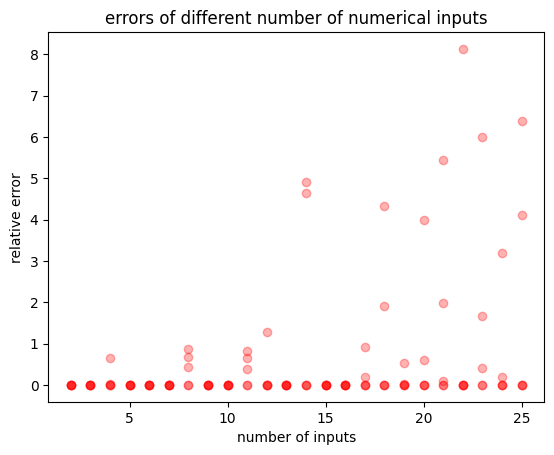

In [63]:
# plots errors
print(errors)
plt.plot(Nvars, errors, 'ro', alpha=0.3) # *** need to fix indexes --> from 1 to nvars
# *** fix this to plot relative error at the end of the DLG process
plt.title('errors of different number of numerical inputs')
plt.xlabel('number of inputs')
plt.ylabel('relative error')
plt.savefig('dlg_brazpd_ninputs-errors.png', dpi=300)
plt.show()

# DLG Evolution

In [42]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 1000
batch_size = 1
dlg_rate = 10
verbose = True
net, train_data, train_target, test_data, test_target, input_dim, output_dim, scaler = setup_net(inp_cnt_num = 9, inp_cnt_cat = 16)

losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                            gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=2000, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = False)

test_net(net, test_data, test_target)

numerical variables: ['CenterSizenpatients' 'Age' 'Primaryrenaldisease' 'DaviesScore'
 'Familyincome' 'timeofpredialysiscare' 'Centerexperiencepatientyear'
 'BMI' 'Distancefromcenter']
[[128.        71.2       81.       ...  30.763889  20.7        1.      ]
 [128.        23.3        0.       ...  30.763889  28.3        1.      ]
 [128.        49.2       81.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.        50.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2       50.       ...  16.416667  35.         1.      ]
 [ 66.        77.8       81.       ...  16.416667  20.6        3.      ]]
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]
categorical variables: ['IncidentinPD' 'PrevalentinPDNet' 'PreviousHD' 'Previoustx'
 'Peripheralarterydisease' 'Cancer' 'Stroke' 'Hypertension' 'HIV' 'HCV'
 'HBC' 'Gender' 'Race' 'predialysiscare' 'Educationdic4y' 'Region']
[[1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 1 ...

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.8000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  2.6900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  5.8000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.5800e+02,  4.6600e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  4.6667e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.5800e+02,  4.6600e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.9000e+01,  5.6100e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         7.2000e+01,  2.6300e+01,  2.4100e+01,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.8999e+01,  5.6100e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  6.9000e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         6.0000e+00,  8.2958e+01,  2.5800e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.3459e+02,  6.6940e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.9000e+01,  4.4800e+01,  1.3000e+01,  2.0000e+00,  3.0000e+00,
         4.8000e+01,  2.5867e+01,  2.5300e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.8999e+01,  4.4800e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6900e+02,  5.6100e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         3.6000e+01,  4.2683e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.6906e+02,  5.6098e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  7.5200e+01,  8.1000e+01, -1.1102e-16,  3.0000e+00,
         3.0000e+00,  8.2958e+01,  2.8300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9800e+02,  7.5200e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  6.0000e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  8.3083e+01,  2.2900e+01,  1.7837e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.6801e+02,  6.0000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.9300e+02, 6.3400e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        5.1944e+01, 2.7700e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.9300e+02,  6.3400e+01,  8.1001e+01,  1.0000e+00,  2.0000e+00,
         2.8728e-04,  5.1944e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9500e+02,  6.7400e+01,  1.3000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  5.9042e+01,  2.2000e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.9499e+02,  6.7400e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  6.5300e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.9438e+01,  2.4200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.5800e+02,  6.5300e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.5000e+01,  5.7200e+01,  0.0000e+00,  2.0000e+00,  4.0000e+00,
         0.0000e+00,  1.3611e+01,  3.2000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.9436e+01,  2.4864e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  6.0000e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         3.6000e+01,  2.3708e+01,  2.6500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.7999e+01,  6.0000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.9000e+01, 7.5900e+01, 1.0000e+02, 1.0000e+00, 2.0000e+00, 8.0000e+00,
        1.1896e+01, 2.0600e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.9003e+01,  7.5900e+01,  9.9998e+01,  9.9999e-01,  2.0000e+00,
         7.9990e+00,  1.1896e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 8.7600e+01, 8.1000e+01, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.9983e+01, 2.1600e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.1100e+02,  8.7600e+01,  8.0998e+01,  2.0000e+00,  2.0000e+00,
        -9.5683e-04,  2.9983e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.1000e+01,  7.7200e+01,  1.0000e+01,  1.0000e+00,  1.0000e+00,
         2.9000e+01,  1.0217e+01,  2.3200e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.0995e+01,  7.7200e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0100e+02,  1.9600e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         7.4000e+01,  3.1153e+01,  1.9900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.7091e+01, -4.0059e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 6.6600e+01, 8.1000e+01, 3.0000e+00, 2.0000e+00, 4.0000e+00,
        8.9438e+01, 2.6600e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.5801e+02,  6.6600e+01,  8.0995e+01,  3.0000e+00,  2.0000e+00,
         3.9985e+00,  8.9437e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.3000e+01,  8.6200e+01,  8.1000e+01,  2.0000e+00,  4.0000e+00,
         2.9000e+01,  7.0278e+00,  2.4800e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.6630e+02,  1.1647e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  5.9700e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.3083e+01,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.3447e+02,  8.1885e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+02,  6.3000e+01,  8.1000e+01,  1.0000e+00,  4.0000e+00,
         0.0000e+00,  4.8681e+01,  2.3200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.2271e+02,  1.5945e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  5.7300e+01,  5.0000e+01,  2.0000e+00,  2.0000e+00,
         3.0000e+00,  8.2958e+01,  2.4100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.9368e+02,  1.0878e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.0000e+01,  3.1300e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  1.2847e+01,  2.4696e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.0329e+01,  2.9122e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.1000e+01,  8.6900e+01,  8.1000e+01,  1.0000e+00,  6.0000e+00,
         4.2000e+01,  1.7222e+01,  3.0000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.1296e+01,  8.7257e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4600e+02,  6.6000e+01,  1.0000e+02, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  4.3900e+01,  2.6400e+01,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4599e+02,  6.6000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.6000e+01,  5.2100e+01,  1.3000e+01,  2.0000e+00,  2.0000e+00,
         8.9000e+01,  2.2567e+01,  4.0300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.6000e+01,  5.2100e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0400e+02,  3.0100e+01,  8.1000e+01,  2.0000e+00,  3.0000e+00,
         2.8000e+01,  3.7333e+01,  2.1100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0609e+02,  2.9963e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9000e+01,  6.9100e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         2.4000e+01,  1.1896e+01,  4.0000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9003e+01,  6.9100e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+02, 5.9900e+01, 8.1000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        8.1972e+01, 3.1200e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 3.2000e+02,  5.9900e+01,  8.1001e+01,  2.0000e+00,  9.9998e-01,
        -1.6706e-04,  8.1972e+01,  3.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  7.8800e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         4.8000e+01,  3.5217e+01,  2.2000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.3556e+02,  7.6748e+00,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  7.1500e+01,  2.0000e+01,  1.0000e+00,  2.0000e+00,
         4.1000e+01,  1.5750e+01,  3.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.4001e+01,  7.1500e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.5000e+01,  8.5000e+01,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         2.7000e+01,  1.3611e+01,  2.1900e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.4149e+02,  1.6618e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  7.1300e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         6.0000e+00,  2.7117e+01,  2.5700e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-9.2967e+02,  1.0255e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0900e+02,  8.4300e+01,  1.0000e+02,  1.0000e+00,  3.0000e+00,
         1.3000e+01,  6.2361e+01,  2.1800e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.7106e+02,  2.0349e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9300e+02,  8.6400e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  5.1944e+01,  2.2100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-3.8842e+01,  1.1705e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  6.4400e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  6.5958e+01,  2.8200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.0301e+02,  6.4400e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 2.9200e+01, 1.0000e+02, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        6.5958e+01, 2.0400e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.0301e+02,  2.9199e+01,  1.0000e+02,  2.0000e+00,  2.0000e+00,
        -9.5150e-04,  6.5958e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0000e+01,  3.5700e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         2.2000e+01,  1.5817e+01,  1.8900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9998e+01,  3.5699e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0200e+02,  8.1200e+01,  1.0000e+02,  2.0000e+00,  1.0000e+00,
         6.0000e+00,  2.9236e+01,  1.9500e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0200e+02,  8.1201e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  4.6600e+01,  1.0000e+01, -1.1102e-16,  1.0000e+00,
         2.0000e+00,  2.4889e+01,  2.3900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2400e+02,  4.6599e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.1000e+01,  6.5700e+01,  8.1000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  2.7117e+01,  2.3600e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.1053e+01,  6.5698e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4300e+02,  4.5800e+01,  5.0000e+01, -1.1102e-16,  1.0000e+00,
         1.2000e+02,  2.9000e+01,  3.3600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4300e+02,  4.5800e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0200e+02,  5.6100e+01,  8.1000e+01,  2.0000e+00,  1.0000e+00,
         1.1000e+01,  2.9236e+01,  2.8000e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0200e+02,  5.6099e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.0000e+01,  7.7400e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         8.0000e+00,  9.9444e+00,  2.2800e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.9995e+01,  7.7399e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.9300e+02, 7.4100e+01, 5.0000e+01, 1.0000e+00, 1.0000e+00, 9.6000e+01,
        5.1944e+01, 2.2200e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.9230e+02,  7.4146e+01,  4.9927e+01,  9.9557e-01,  9.8301e-01,
         9.5839e+01,  5.1722e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9000e+01,  4.0900e+01,  0.0000e+00, -1.1102e-16, -2.2204e-16,
         3.0000e+00,  8.4500e+00,  2.3700e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9005e+01,  4.0901e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0200e+02,  5.1200e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         7.4000e+01,  2.9236e+01,  2.5800e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-5.5802e+02,  7.9234e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.0400e+02,  5.0700e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         1.4000e+01,  3.7333e+01,  2.6000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-4.9802e+02,  1.2949e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.0300e+02, 6.8900e+01, 8.1000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        6.5958e+01, 1.9200e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.0402e+02,  6.8825e+01,  8.0882e+01,  9.9875e-01,  1.0206e+00,
        -5.2316e-02,  6.6184e+01,  1.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.7000e+01, 3.7800e+01, 8.1000e+01, 1.0000e+00, 2.0000e+00, 4.0000e+00,
        1.2750e+01, 2.9000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([-3.7318e+02, -7.9289e+01, -1.4504e+02, -5.6270e+00,  5.9074e+00,
         2.4234e+02,  9.6731e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  2.6900e+01,  1.0000e+01, -1.1102e-16,  3.0000e+00,
         2.0000e+00,  8.2958e+01,  1.6400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9800e+02,  2.6900e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1000e+02,  6.1700e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  3.4931e+01,  2.4100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.1000e+02,  6.1700e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  4.7900e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  2.0792e+01,  1.9300e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.6897e+01,  4.8528e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 7.0700e+01, 1.0000e+01, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        2.9983e+01, 2.0300e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.1100e+02,  7.0700e+01,  1.0000e+01,  2.0000e+00,  2.0000e+00,
         3.0002e+00,  2.9983e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  8.3600e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  7.5000e+00,  2.4696e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.2002e+01,  8.3600e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.8000e+01,  7.7200e+01,  1.0000e+02,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  8.0417e+00,  1.9200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.1102e-16,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.7769e+01,  7.7275e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  7.2200e+01,  8.1000e+01,  2.0000e+00,  2.0000e+00,
         0.0000e+00,  2.3708e+01,  2.6300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.7839e+02,  1.1836e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.2200e+02,  6.8000e+01,  0.0000e+00,  1.0000e+00,  2.0000e+00,
         3.6000e+01,  4.9292e+01,  2.9300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.2200e+02,  6.8000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.0300e+02,  5.9800e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  6.5958e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.0300e+02,  5.9800e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 7.1300e+01, 8.1000e+01, 2.0000e+00, 2.0000e+00, 1.2000e+01,
        2.9983e+01, 2.9800e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.8001e+02,  1.2080e+02,  3.0440e+02,  1.4822e+00,  2.7689e+00,
         1.6532e+02,  8.7899e+01,  5.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  5.5900e+01,  3.0000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  2.7500e+01,  2.5100e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.1200e+02,  5.5900e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.5800e+02,  7.2900e+01,  1.0000e+02,  2.0000e+00,  2.0000e+00,
         6.0000e+00,  4.6667e+01,  3.7300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.5800e+02,  7.2900e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 8.9000e+01,  4.1300e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         1.2000e+01,  2.5867e+01,  2.7300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 8.2562e+01,  7.3145e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9300e+02,  7.2600e+01,  2.0000e+01, -1.1102e-16,  2.0000e+00,
         1.2000e+01,  5.1944e+01,  2.4600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.0167e+02,  1.2305e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.8000e+01,  6.7200e+01,  8.1000e+01,  2.0000e+00,  3.0000e+00,
         3.7000e+01,  1.4653e+01,  2.3400e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-6.3929e+02,  5.7284e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 7.4500e+01, 1.0000e+01, 1.0000e+00, 3.0000e+00, 1.2000e+01,
        2.9983e+01, 2.4400e+01, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.1100e+02,  7.4500e+01,  9.9996e+00,  9.9999e-01,  3.0001e+00,
         1.2000e+01,  2.9983e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 7.6900e+01, 8.1000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        2.9983e+01, 2.4800e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 1.1100e+02,  7.6899e+01,  8.0997e+01,  2.0000e+00,  1.0001e+00,
         8.5342e-04,  2.9984e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.4000e+01,  7.7100e+01,  0.0000e+00,  2.0000e+00,  2.0000e+00,
         3.0000e+00,  1.9472e+01,  2.4900e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.7464e+01,  6.9785e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.3100e+02,  4.4100e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  4.3479e+01,  2.2000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4579e+03,  1.0173e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.1000e+01,  8.0400e+01,  0.0000e+00, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  1.7222e+01,  2.4696e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-1.6084e+03,  2.2721e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.2000e+02,  7.8400e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         3.6000e+01,  8.1972e+01,  2.5700e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.2000e+02,  7.8400e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  6.1200e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3708e+01,  2.8500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.8004e+01,  6.1199e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.4000e+02,  3.0800e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  5.8833e+01,  1.8000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.4000e+02,  3.0800e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.6000e+01,  4.6000e+01,  1.0000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  2.2567e+01,  3.4600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.6002e+01,  4.6000e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.0000e+01,  3.9700e+01,  3.0000e+01, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.3889e+01,  2.3900e+01,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.9993e+01,  3.9693e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.9000e+01,  7.3200e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  2.5033e+01,  2.2600e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.6593e+01,  5.9539e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.6100e+02,  7.2200e+01,  3.0000e+01, -1.1102e-16,  1.0000e+00,
         6.0000e+01,  3.8050e+01,  2.2300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.6100e+02,  7.2199e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.8000e+01,  7.7000e+01,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         0.0000e+00,  2.3708e+01,  2.3300e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 9.8002e+01,  7.6999e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2400e+02,  4.7000e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         3.0000e+00,  3.4681e+01,  2.1600e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2399e+02,  4.7002e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.3000e+01,  7.6700e+01,  5.0000e+01,  1.0000e+00,  4.0000e+00,
         7.4000e+01,  7.0278e+00,  2.3200e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.3001e+01,  7.6700e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  4.9400e+01,  5.0000e+01,  1.0000e+00,  1.0000e+00,
         6.0000e+00,  8.2958e+01,  2.6500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 3.9799e+02,  4.9402e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  7.6600e+01,  5.0000e+01, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.3083e+01,  2.9500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 2.6800e+02,  7.6601e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.1200e+02,  3.6900e+01,  0.0000e+00, -1.1102e-16,  3.0000e+00,
         0.0000e+00,  3.5217e+01,  2.9500e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.1201e+02,  3.6898e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([9.1000e+01, 6.3100e+01, 8.1000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        3.2972e+01, 3.5900e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 4.1470e+01,  1.4247e+02,  2.7469e+02,  1.3143e+00,  1.1471e+00,
         1.3026e+02,  5.4457e+00,  3.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.7100e+02,  9.4600e+01,  1.0000e+02,  1.0000e+00,  3.0000e+00,
         2.4000e+01,  4.2042e+01,  2.3200e+01,  5.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.7100e+02,  9.4599e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.7100e+02,  6.7200e+01,  8.1000e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  4.2042e+01,  2.3400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.7100e+02,  6.7201e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2000e+01,  4.9600e+01,  1.0000e+01, -1.1102e-16,  2.0000e+00,
         3.8000e+01,  6.9722e+00,  2.1800e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2003e+01,  4.9599e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  8.1800e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         1.7000e+01,  8.2958e+01,  2.6200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.0970e+03,  5.9351e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.9500e+02,  5.5900e+01,  8.1000e+01,  1.0000e+00,  3.0000e+00,
         0.0000e+00,  5.9042e+01,  2.4200e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.5303e+02,  4.8894e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([9.3000e+01, 5.6000e+01, 1.0000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        2.7200e+01, 2.1800e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 9.3007e+01,  5.5998e+01,  1.0001e+01,  9.9999e-01,  1.0002e+00,
         2.2324e-03,  2.7201e+01,  2.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.7100e+02,  4.5400e+01,  8.1000e+01, -1.1102e-16,  1.0000e+00,
         0.0000e+00,  4.2042e+01,  2.5100e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.7100e+02,  4.5399e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6800e+02,  4.6700e+01,  8.1000e+01,  1.0000e+00,  2.0000e+00,
         5.0000e+00,  8.3083e+01,  2.9000e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 6.8685e+02,  7.5339e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.8000e+01,  6.6200e+01,  5.0000e+01,  2.0000e+00,  2.0000e+00,
         3.6000e+01,  1.4653e+01,  2.9300e+01,  2.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2973e+02,  1.0176e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+02, 4.4000e+01, 1.0000e+01, 1.0000e+00, 3.0000e+00, 3.0000e+00,
        8.1972e+01, 2.6000e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 8.6736e-19, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64) tensor([ 5.6624e+02,  9.0007e+01, -8.7667e+01,  1.1070e+01,  2.4155e+00,
         5.2605e+01,  1.5229e+02,  1.

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.5800e+02,  7.4000e+01,  8.1000e+01,  3.0000e+00,  2.0000e+00,
         2.4000e+01,  4.6667e+01,  2.7200e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.6266e+02,  8.1270e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  4.8600e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  8.1625e+01,  3.1600e+01,  3.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([-4.2649e+01,  1.2400e+02,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 5.1000e+01,  5.7400e+01,  0.0000e+00, -1.1102e-16,  2.0000e+00,
         1.2000e+01,  8.5667e+00,  2.2100e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 5.1000e+01,  5.7400e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.0000e+02,  5.7100e+01,  5.0000e+01,  1.0000e+00,  2.0000e+00,
         0.0000e+00,  4.8681e+01,  2.2400e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 4.8812e+02,  9.4165e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.9800e+02,  2.3400e+01,  1.3000e+01,  1.0000e+00,  1.0000e+00,
         2.0000e+00,  8.2958e+01,  2.5000e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
        -2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 7.8090e+02,  2.1600e+01,

  0%|          | 0/2000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 1.2800e+02,  6.8700e+01,  1.0000e+02, -1.1102e-16,  2.0000e+00,
         0.0000e+00,  3.0764e+01,  2.3900e+01,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7756e-17,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64) tensor([ 1.2800e+02,  6.8701e+01,

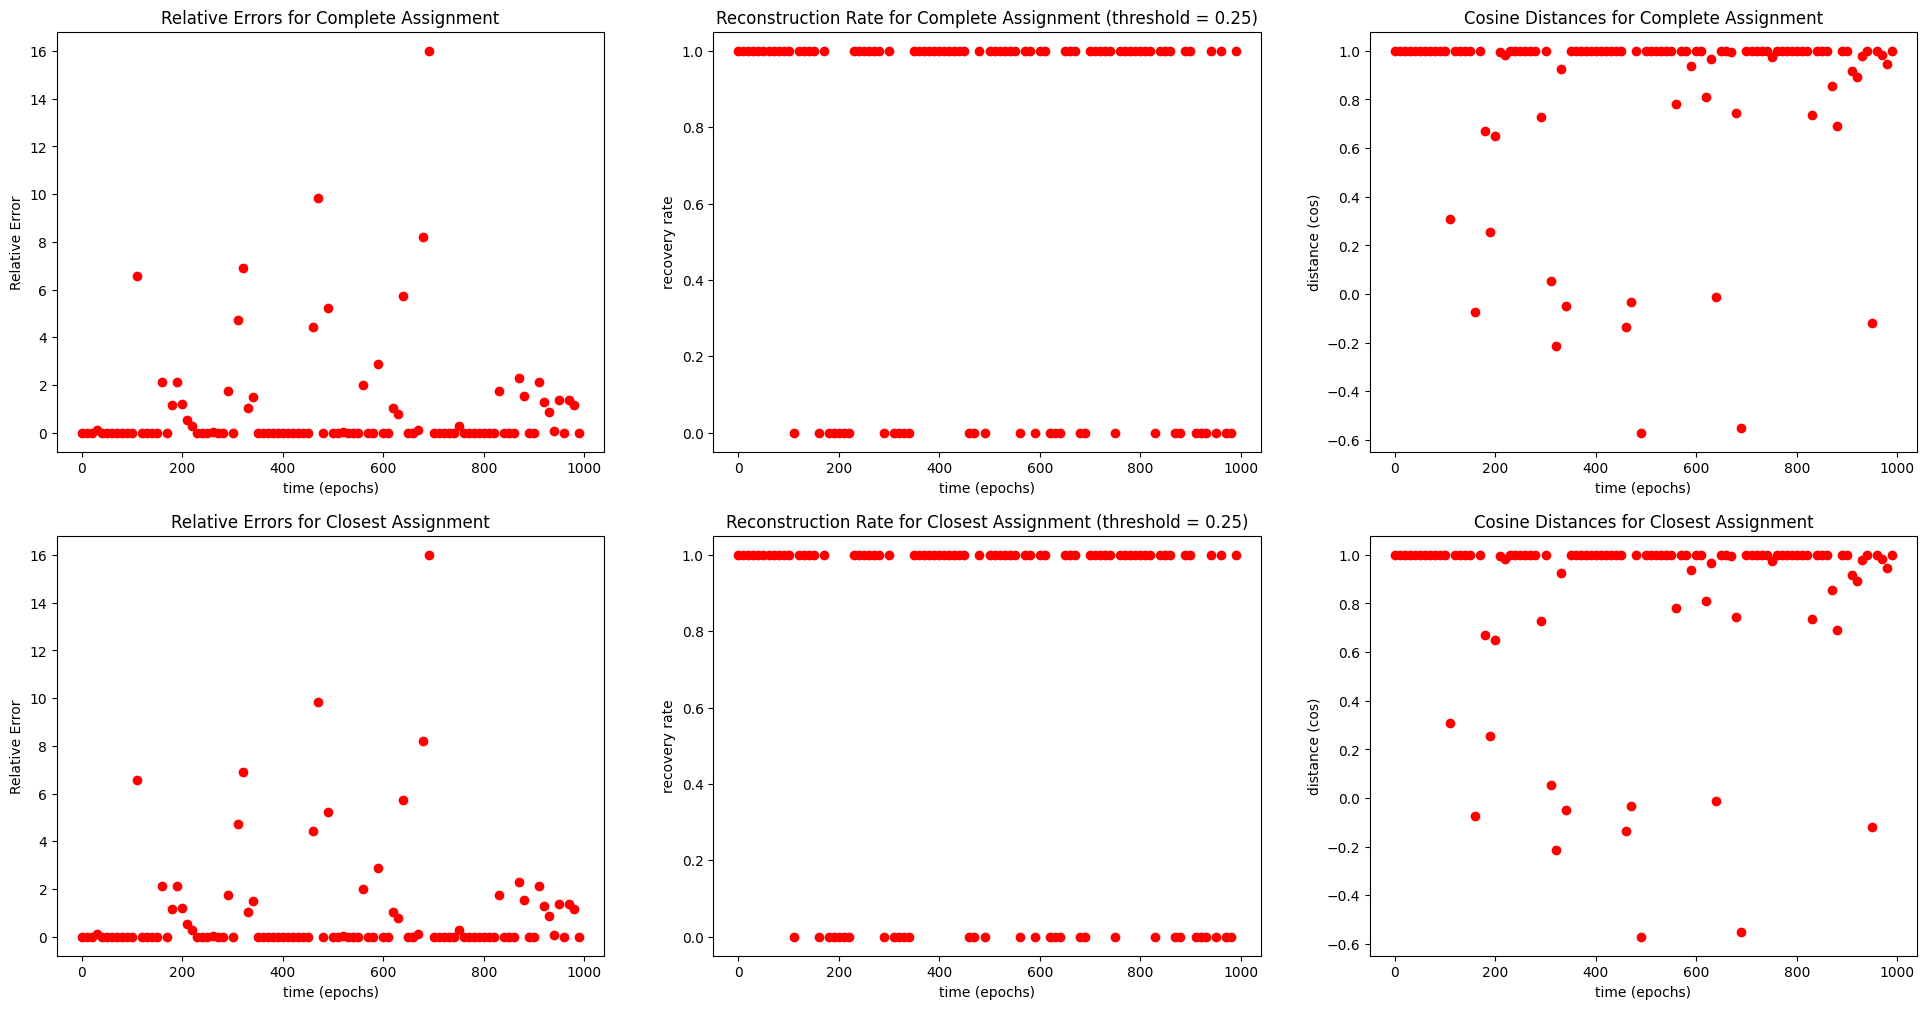

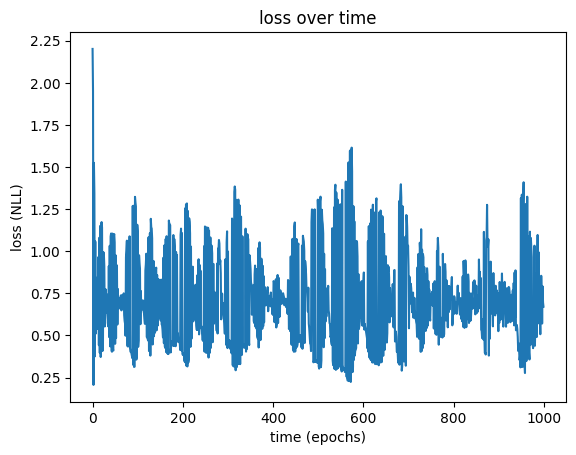

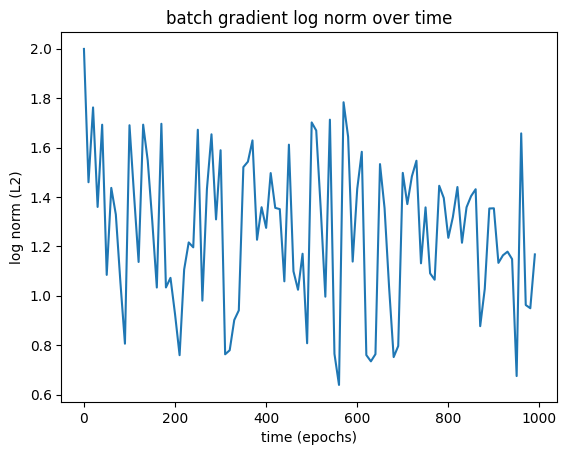

In [43]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_BRAZPD_1-r.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_BRAZPD_1_loss-r.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_BRAZPD_1_norm-r.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo

# future tasks -----------------------------------------------------------
# possibly modify single batch DLG rather than having to run DLG Evolution (debugging purposes --> can already simulate on DLG evolution epochs=1)
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)